In [1]:
import numpy as np
import pandas as pd
import re
import time
import torch
import torch.nn as nn
import wandb
import random
import math
import itertools
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, BertPreTrainedModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from kaggle_secrets import UserSecretsClient

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [5]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [10]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [11]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [12]:
filename = 'netifier-mc'
epochs = 10
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, trials, mc_passes=3, n_samples=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)

    model.train()  # Set model to train mode to activate dropout layers
    confidences = []

    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=80)
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
    )

    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)

    # Select samples with highest uncertainty
    uncertainties = np.array(confidences)
    sorted = np.argsort(confidences)
    sorted = sorted[::-1]

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    num_of_candidates = len(items_greater_than_average)

    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break
            
    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        most_uncertain_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
         most_uncertain_indices = sorted[:num_of_candidates]
    else:
        most_uncertain_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(most_uncertain_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(most_uncertain_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed
    
    sampling_dur.append(duration)

    return [remaining_indices[i] for i in most_uncertain_indices]

In [14]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 9:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=128)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=128)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [16]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = monte_carlo_dropout_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
            mc_passes=3,
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241222_143336-jx2b3vwh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-mc-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/jx2b3vwh


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.471070,0.441801,0.722222,0.009804,0.019345,0.016121
2,No log,0.408955,0.549839,0.937743,0.181750,0.304485,0.212706
3,No log,0.356134,0.570418,0.760807,0.398190,0.522772,0.458811
4,No log,0.333005,0.578135,0.745169,0.465309,0.572888,0.519570
5,No log,0.328695,0.599357,0.754325,0.493213,0.596443,0.562729
6,No log,0.316878,0.602572,0.734064,0.555807,0.632618,0.600391
7,No log,0.322708,0.605788,0.756849,0.500000,0.602180,0.576849
8,No log,0.310757,0.618006,0.728030,0.593514,0.653926,0.632917
9,No log,0.310798,0.616720,0.731638,0.585973,0.650754,0.631457
10,No log,0.310642,0.616077,0.733840,0.582202,0.649285,0.630442


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6180064308681672, F1 Micro: 0.653926049023681, F1 Macro: 0.6329171582051338
                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0037122295238077646
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 42.75436043739319 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.391411,0.571704,0.772321,0.391403,0.519520,0.448362
2,No log,0.325539,0.630225,0.720790,0.632730,0.673896,0.665184
3,No log,0.292547,0.660450,0.739348,0.667421,0.701546,0.702073
4,No log,0.278147,0.671383,0.743039,0.704374,0.723190,0.711355
5,No log,0.274168,0.682958,0.770213,0.682504,0.723711,0.714199
6,No log,0.275583,0.684244,0.753773,0.715686,0.734236,0.722357
7,No log,0.278568,0.684887,0.753510,0.728507,0.740798,0.733156
8,No log,0.277837,0.682315,0.779029,0.677979,0.725000,0.711583
9,0.297300,0.280387,0.682315,0.768724,0.704374,0.735144,0.725812
10,0.297300,0.280855,0.687460,0.768163,0.709653,0.737750,0.729150


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.85      0.88       362
                sara       0.66      0.57      0.61       237
         radikalisme       0.69      0.80      0.74       235
pencemaran_nama_baik       0.72      0.68      0.70       492

           micro avg       0.75      0.73      0.74      1326
           macro avg       0.74      0.73      0.73      1326
        weighted avg       0.76      0.73      0.74      1326
         samples avg       0.40      0.40      0.39      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.684887459807074, F1 Micro: 0.7407975460122699, F1 Macro: 0.7331556826031785
                      precision    recall  f1-score   support

          pornografi       0.91      0.85      0.88       362
                sara       0.66      0.57      0.61       237
         radikalisme       0.69      0.80      0.74       235
pencemaran_nama_baik       0.72      0.68      0.70       492

           micro avg       0.75      0.73      0.74      1326
           macro avg       0.74      0.73      0.73      1326
        weighted avg       0.76      0.73      0.74      1326
         samples avg       0.40      0.40      0.39      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0043843988329172155
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 38.81223487854004 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.358507,0.576206,0.771684,0.456259,0.573460,0.533854
2,No log,0.302697,0.654662,0.743151,0.654600,0.696071,0.693881
3,No log,0.268715,0.682315,0.768781,0.694570,0.729794,0.722614
4,No log,0.264375,0.683601,0.744100,0.760935,0.752424,0.741818
5,No log,0.263894,0.699035,0.755788,0.763198,0.759475,0.751821
6,0.353400,0.269437,0.687460,0.787381,0.687029,0.733790,0.724177
7,0.353400,0.272703,0.693248,0.762646,0.739065,0.750670,0.740594
8,0.353400,0.276778,0.700322,0.756960,0.758673,0.757815,0.748702
9,0.353400,0.276040,0.696463,0.762238,0.739819,0.750861,0.741691
10,0.353400,0.278844,0.697749,0.763158,0.743590,0.753247,0.743168


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.85      0.89       362
                sara       0.66      0.61      0.64       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.42      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6990353697749196, F1 Micro: 0.7594746716697935, F1 Macro: 0.7518212187090552
                      precision    recall  f1-score   support

          pornografi       0.93      0.85      0.89       362
                sara       0.66      0.61      0.64       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.42      0.42      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0029603261034935762
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 34.831881523132324 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.341465,0.583280,0.819596,0.397436,0.535297,0.485240
2,No log,0.284544,0.669453,0.771479,0.656863,0.709572,0.697877
3,No log,0.260159,0.695820,0.751479,0.766214,0.758775,0.755772
4,No log,0.250470,0.705466,0.778391,0.744344,0.760987,0.751888
5,0.375800,0.267137,0.694534,0.724255,0.806184,0.763026,0.759579
6,0.375800,0.252393,0.705466,0.770706,0.757919,0.764259,0.756059
7,0.375800,0.263822,0.705466,0.758697,0.773002,0.765783,0.758139
8,0.375800,0.263630,0.702894,0.776368,0.738311,0.756861,0.749055
9,0.197100,0.270349,0.701608,0.764172,0.762443,0.763307,0.752699
10,0.197100,0.269905,0.704180,0.769946,0.749623,0.759648,0.751123


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.62      0.63      0.62       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.76      0.77      0.77      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.76      0.77      0.77      1326
         samples avg       0.43      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.7054662379421222, F1 Micro: 0.7657825924542399, F1 Macro: 0.7581393056871597
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.62      0.63      0.62       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.76      0.77      0.77      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.76      0.77      0.77      1326
         samples avg       0.43      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0037869513500481886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 31.41926670074463 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.327614,0.639871,0.739796,0.656109,0.695444,0.680523
2,No log,0.266465,0.682315,0.774648,0.705128,0.738255,0.726481
3,No log,0.250000,0.693248,0.762384,0.742836,0.752483,0.749841
4,0.382000,0.248055,0.699678,0.783388,0.725490,0.753328,0.749014
5,0.382000,0.246390,0.713826,0.800163,0.739819,0.768809,0.757227
6,0.382000,0.260871,0.705466,0.752696,0.789593,0.770703,0.764647
7,0.214500,0.265592,0.710611,0.775557,0.760935,0.768177,0.759098
8,0.214500,0.266347,0.710611,0.796540,0.729261,0.761417,0.752298
9,0.214500,0.268857,0.709325,0.781348,0.751885,0.766334,0.757009
10,0.141400,0.273417,0.706109,0.770928,0.763952,0.767424,0.758991


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.62      0.65      0.64       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.79      0.76      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7054662379421222, F1 Micro: 0.770702981229297, F1 Macro: 0.764647251433514
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.62      0.65      0.64       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.79      0.76      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0025590402539819508
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 28.22708797454834 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.316988,0.639228,0.736527,0.649321,0.690180,0.669646
2,No log,0.258468,0.700965,0.758929,0.769231,0.764045,0.755652
3,0.385700,0.246291,0.705466,0.768997,0.763198,0.766086,0.752729
4,0.385700,0.243415,0.706109,0.786806,0.737557,0.761386,0.750260
5,0.385700,0.254059,0.708039,0.751601,0.796380,0.773343,0.770117
6,0.234400,0.253368,0.709968,0.783217,0.760181,0.771527,0.764219
7,0.234400,0.255732,0.709325,0.787855,0.753394,0.770239,0.761804
8,0.234400,0.263284,0.711254,0.786109,0.751131,0.768222,0.759216
9,0.154600,0.271504,0.707395,0.777182,0.765460,0.771277,0.763703
10,0.154600,0.272928,0.708682,0.773828,0.771493,0.772659,0.766601


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.60      0.72      0.65       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.74      0.73      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7080385852090032, F1 Micro: 0.7733430977663859, F1 Macro: 0.7701166230482075
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.60      0.72      0.65       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.74      0.73      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0014893494080752134
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 25.677059173583984 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.300254,0.655949,0.790323,0.628205,0.700000,0.685972
2,No log,0.250092,0.698392,0.769290,0.751885,0.760488,0.746204
3,0.384000,0.236040,0.718328,0.774096,0.775264,0.774680,0.767571
4,0.384000,0.242218,0.715113,0.762111,0.794872,0.778147,0.770255
5,0.384000,0.243840,0.717685,0.783826,0.760181,0.771822,0.766180
6,0.238900,0.269982,0.697106,0.733016,0.813725,0.771265,0.764508
7,0.238900,0.261978,0.720257,0.799517,0.748869,0.773364,0.763112
8,0.160700,0.268397,0.718971,0.786770,0.762443,0.774416,0.765599
9,0.160700,0.276032,0.715113,0.767923,0.783560,0.775663,0.770093
10,0.160700,0.277394,0.711897,0.775495,0.768477,0.771970,0.763676


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.73      0.85      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.715112540192926, F1 Micro: 0.7781469176818013, F1 Macro: 0.7702549304987261
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.73      0.85      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.001167353184428066
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 22.9654860496521 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.286482,0.666881,0.773486,0.664404,0.714807,0.707058
2,No log,0.241898,0.713826,0.776744,0.755656,0.766055,0.755488
3,0.380400,0.232728,0.724116,0.771261,0.793363,0.782156,0.775084
4,0.380400,0.231455,0.724759,0.771137,0.797888,0.784285,0.778391
5,0.243100,0.240721,0.717042,0.774701,0.780543,0.777611,0.770235
6,0.243100,0.259368,0.719614,0.745957,0.834842,0.787900,0.784118
7,0.167600,0.264938,0.722186,0.766836,0.798643,0.782416,0.774891
8,0.167600,0.264219,0.714469,0.765926,0.779789,0.772795,0.768552
9,0.167600,0.267896,0.717042,0.771471,0.779035,0.775235,0.769852
10,0.120400,0.271918,0.717042,0.772218,0.779789,0.775985,0.770541


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.64      0.72      0.68       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.75      0.83      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7196141479099678, F1 Micro: 0.7879003558718861, F1 Macro: 0.7841183771686819
                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.64      0.72      0.68       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.75      0.83      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0010396922007203102
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 20.733506441116333 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.277083,0.700322,0.744404,0.777526,0.760605,0.754797
2,No log,0.236592,0.709968,0.766642,0.773002,0.769808,0.762282
3,0.375000,0.231749,0.724116,0.779970,0.775264,0.777610,0.770484
4,0.375000,0.230400,0.716399,0.776946,0.782805,0.779865,0.772104
5,0.241600,0.239476,0.720900,0.777695,0.788839,0.783227,0.778131
6,0.241600,0.242935,0.721543,0.776699,0.784314,0.780488,0.773960
7,0.172900,0.263023,0.715756,0.764663,0.796380,0.780199,0.775175
8,0.172900,0.267312,0.716399,0.762931,0.800905,0.781457,0.778499
9,0.122500,0.273388,0.720257,0.767054,0.797134,0.781805,0.778595
10,0.122500,0.272519,0.713183,0.771471,0.779035,0.775235,0.771172


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.68      0.65      0.66       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7209003215434083, F1 Micro: 0.7832272557094722, F1 Macro: 0.7781305200971759
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.68      0.65      0.66       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0004441057273652405
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 18.850395917892456 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273403,0.682315,0.771064,0.683258,0.724510,0.714418
2,No log,0.240554,0.700965,0.751089,0.780543,0.765533,0.754707
3,0.372700,0.236182,0.715113,0.750347,0.815988,0.781792,0.774734
4,0.372700,0.232364,0.722830,0.765512,0.800151,0.782448,0.775927
5,0.246800,0.236299,0.718971,0.769853,0.789593,0.779598,0.772192
6,0.246800,0.247549,0.721543,0.783308,0.771493,0.777356,0.768516
7,0.175300,0.255522,0.717685,0.777862,0.773756,0.775803,0.768272
8,0.175300,0.262783,0.715113,0.779061,0.763198,0.771048,0.761807
9,0.129300,0.273988,0.709968,0.760522,0.790347,0.775148,0.771224
10,0.129300,0.272845,0.715113,0.771364,0.776018,0.773684,0.766602


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7228295819935692, F1 Micro: 0.782448377581121, F1 Macro: 0.7759266391580731
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0004839779634494341
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 17.428792238235474 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273321,0.661736,0.807613,0.592006,0.683203,0.666123
2,0.370400,0.240362,0.705466,0.785831,0.727753,0.755677,0.741176
3,0.370400,0.228986,0.718328,0.790845,0.755656,0.772850,0.764413
4,0.241400,0.232837,0.715756,0.783763,0.757164,0.770234,0.760931
5,0.241400,0.237882,0.724116,0.803079,0.747360,0.774219,0.765565
6,0.178100,0.244719,0.722830,0.772894,0.795626,0.784095,0.775563
7,0.178100,0.255468,0.719614,0.783077,0.767722,0.775324,0.766674
8,0.132000,0.271263,0.718328,0.762797,0.797888,0.779948,0.775530
9,0.132000,0.273861,0.715756,0.772388,0.780543,0.776444,0.769548
10,0.103000,0.273809,0.714469,0.770896,0.779035,0.774944,0.769231


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.64      0.63      0.64       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7228295819935692, F1 Micro: 0.7840951319212188, F1 Macro: 0.7755633024626885
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.64      0.63      0.64       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00019375621195649723
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 15.685022354125977 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.265739,0.675241,0.819939,0.607843,0.698138,0.683209
2,0.362200,0.238680,0.706109,0.748043,0.792609,0.769681,0.762714
3,0.362200,0.237475,0.713826,0.751404,0.806938,0.778182,0.774116
4,0.241000,0.229748,0.719614,0.790182,0.752640,0.770954,0.762458
5,0.241000,0.247521,0.713826,0.742373,0.825792,0.781864,0.774763
6,0.179000,0.266192,0.716399,0.746021,0.812971,0.778058,0.772831
7,0.179000,0.261367,0.721543,0.783599,0.778281,0.780931,0.768647
8,0.128700,0.266348,0.722186,0.787879,0.764706,0.776119,0.766230
9,0.128700,0.281848,0.715756,0.759885,0.797134,0.778064,0.770569
10,0.101900,0.275781,0.717685,0.775188,0.777526,0.776355,0.768090


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.69      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7138263665594855, F1 Micro: 0.7818636201356658, F1 Macro: 0.7747625683999938
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.69      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0001965036077308468
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 14.082984685897827 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270178,0.673312,0.831915,0.589744,0.690203,0.671588
2,0.356500,0.232103,0.719614,0.766176,0.785822,0.775875,0.768269
3,0.356500,0.224454,0.718328,0.806291,0.734540,0.768745,0.755514
4,0.239000,0.226804,0.722830,0.784358,0.779035,0.781687,0.773639
5,0.239000,0.243628,0.708682,0.770787,0.776018,0.773393,0.760987
6,0.177500,0.246984,0.722830,0.784615,0.769231,0.776847,0.767346
7,0.177500,0.257809,0.722186,0.770528,0.792609,0.781413,0.772746
8,0.133500,0.270831,0.720900,0.771619,0.787330,0.779395,0.771328
9,0.100800,0.274725,0.722186,0.775112,0.779789,0.777444,0.768114
10,0.100800,0.278245,0.719614,0.772727,0.782051,0.777361,0.768723


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7228295819935692, F1 Micro: 0.7816874763526296, F1 Macro: 0.7736390199113337
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0001278338924748823
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 12.73984694480896 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.261679,0.676527,0.736462,0.769231,0.752490,0.739129
2,0.350400,0.236747,0.719614,0.779908,0.766968,0.773384,0.756532
3,0.350400,0.223803,0.717685,0.772961,0.793363,0.783029,0.776036
4,0.235600,0.228910,0.722186,0.787739,0.775264,0.781452,0.774414
5,0.235600,0.240446,0.731833,0.791251,0.777526,0.784329,0.778369
6,0.181400,0.256037,0.724116,0.770803,0.796380,0.783383,0.776361
7,0.129600,0.260420,0.723473,0.778027,0.785068,0.781532,0.772961
8,0.129600,0.274220,0.722830,0.768390,0.795626,0.781771,0.775113
9,0.101100,0.279582,0.718328,0.770772,0.783560,0.777113,0.770130
10,0.101100,0.284586,0.718328,0.768053,0.794118,0.780868,0.774687


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.70      0.64      0.67       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7318327974276527, F1 Micro: 0.7843286420692278, F1 Macro: 0.7783688551097502
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.70      0.64      0.67       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 5.351502913981683e-05
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 11.698895692825317 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250214,0.704180,0.755894,0.749623,0.752745,0.748994
2,0.342800,0.232273,0.713183,0.766917,0.769231,0.768072,0.758250
3,0.342800,0.222656,0.718971,0.777441,0.774510,0.775973,0.768787
4,0.231700,0.236017,0.724116,0.809643,0.734540,0.770265,0.758807
5,0.175600,0.242056,0.724116,0.773501,0.788084,0.780725,0.775624
6,0.175600,0.253363,0.720900,0.773472,0.782805,0.778111,0.767743
7,0.128500,0.271346,0.710611,0.757009,0.794118,0.775120,0.767503
8,0.128500,0.278143,0.718328,0.771218,0.788084,0.779560,0.771119
9,0.100800,0.282765,0.717685,0.778452,0.773756,0.776097,0.766746
10,0.078800,0.289106,0.719614,0.770022,0.790347,0.780052,0.771818


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7241157556270097, F1 Micro: 0.7807246918192006, F1 Macro: 0.7756244952048679
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 3.670621008495801e-05
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 10.203747510910034 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248484,0.703537,0.752784,0.764706,0.758698,0.751144
2,0.336300,0.240131,0.714469,0.737508,0.834842,0.783162,0.775318
3,0.336300,0.224970,0.713183,0.793408,0.744344,0.768093,0.753549
4,0.229100,0.229046,0.727331,0.786525,0.783560,0.785040,0.774258
5,0.173900,0.235071,0.727331,0.799054,0.764706,0.781503,0.773044
6,0.173900,0.266652,0.706752,0.738015,0.824284,0.778767,0.774094
7,0.127600,0.273519,0.720257,0.767153,0.792609,0.779674,0.772701
8,0.098800,0.276379,0.719614,0.774459,0.782051,0.778236,0.770341
9,0.098800,0.289791,0.718971,0.768668,0.791855,0.780089,0.773058
10,0.079500,0.288569,0.718971,0.774218,0.783560,0.778861,0.770854


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.70      0.58      0.64       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.75      0.75       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.727331189710611, F1 Micro: 0.7850396675481677, F1 Macro: 0.7742580072855096
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.70      0.58      0.64       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.75      0.75       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 3.357889800099656e-05
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 8.786638498306274 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256706,0.688746,0.726958,0.791101,0.757674,0.742675
2,0.327800,0.230135,0.710611,0.800170,0.709653,0.752198,0.737833
3,0.327800,0.226096,0.718328,0.778116,0.772247,0.775170,0.767583
4,0.228100,0.234105,0.715756,0.766450,0.799397,0.782577,0.779256
5,0.170100,0.250884,0.722186,0.768452,0.800905,0.784343,0.777060
6,0.170100,0.256293,0.716399,0.773501,0.788084,0.780725,0.772359
7,0.127700,0.264883,0.726045,0.790285,0.773002,0.781548,0.773291
8,0.097300,0.282150,0.720900,0.770290,0.801659,0.785661,0.781106
9,0.097300,0.285137,0.719614,0.778940,0.786576,0.782739,0.774932
10,0.077800,0.294343,0.718328,0.766234,0.800905,0.783186,0.778506


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7209003215434083, F1 Micro: 0.7856614929785662, F1 Macro: 0.7811064119120406
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 6.866228522994792e-06
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 7.435049772262573 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246344,0.686174,0.809879,0.655354,0.724469,0.705090
2,0.328000,0.226440,0.709968,0.785544,0.745852,0.765184,0.754346
3,0.217600,0.226511,0.714469,0.767988,0.788839,0.778274,0.772414
4,0.217600,0.230125,0.722830,0.794510,0.763952,0.778931,0.770285
5,0.166200,0.247796,0.720257,0.773460,0.795626,0.784387,0.772880
6,0.129500,0.263263,0.713183,0.767699,0.785068,0.776286,0.766782
7,0.129500,0.274916,0.715756,0.758794,0.797134,0.777492,0.770766
8,0.093000,0.291460,0.714469,0.750520,0.816742,0.782232,0.777277
9,0.077800,0.289250,0.716399,0.767595,0.789593,0.778439,0.769468
10,0.077800,0.296412,0.714469,0.763177,0.797134,0.779786,0.772083


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.65      0.59      0.62       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7202572347266881, F1 Micro: 0.7843866171003717, F1 Macro: 0.772879792928276
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.65      0.59      0.62       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.2177146527392322e-05
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 6.021714210510254 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245041,0.689389,0.814423,0.638763,0.715976,0.698760
2,0.315300,0.229728,0.702251,0.785016,0.726998,0.754894,0.737280
3,0.215300,0.225773,0.723473,0.776065,0.797134,0.786458,0.778135
4,0.215300,0.234841,0.720257,0.790133,0.760935,0.775259,0.760935
5,0.164500,0.244683,0.722830,0.782576,0.779035,0.780801,0.770006
6,0.124100,0.261910,0.726045,0.785332,0.775264,0.780266,0.771984
7,0.124100,0.281370,0.723473,0.769231,0.799397,0.784024,0.779528
8,0.096700,0.287688,0.724759,0.774170,0.791101,0.782544,0.775949
9,0.074500,0.299157,0.719614,0.765130,0.800905,0.782609,0.776538
10,0.065200,0.298529,0.717685,0.773641,0.783560,0.778569,0.771770


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7234726688102894, F1 Micro: 0.7864583333333333, F1 Macro: 0.7781352094629377
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.634669533814303e-05
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 4.5112385749816895 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244893,0.700322,0.770465,0.723982,0.746501,0.744646
2,0.309200,0.226113,0.713183,0.753923,0.797134,0.774927,0.769993
3,0.208200,0.235534,0.713826,0.740691,0.825038,0.780592,0.776944
4,0.208200,0.238116,0.720257,0.770182,0.798643,0.784154,0.778985
5,0.163100,0.246318,0.720900,0.786534,0.775264,0.780858,0.773223
6,0.121800,0.275265,0.717042,0.749315,0.825038,0.785355,0.779900
7,0.093400,0.284702,0.717685,0.763064,0.803922,0.782960,0.775989
8,0.093400,0.287568,0.723473,0.777198,0.786576,0.781859,0.774194
9,0.072600,0.301997,0.720257,0.769899,0.802413,0.785820,0.779849
10,0.062600,0.304627,0.719614,0.766094,0.807692,0.786344,0.780391


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7196141479099678, F1 Micro: 0.7863436123348018, F1 Macro: 0.7803914170707311
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.6822546740513648e-06
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 3.047449827194214 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240792,0.698392,0.776699,0.723982,0.749415,0.737534
2,0.300500,0.224825,0.711897,0.763889,0.788084,0.775798,0.768917
3,0.206400,0.223802,0.718328,0.772761,0.787330,0.779978,0.768835
4,0.162100,0.230025,0.719614,0.782012,0.773756,0.777862,0.770075
5,0.162100,0.248208,0.725402,0.785385,0.769985,0.777609,0.768913
6,0.121100,0.264615,0.713826,0.761733,0.795626,0.778311,0.772475
7,0.094300,0.283172,0.717685,0.765864,0.791855,0.778643,0.771210
8,0.073800,0.289063,0.716399,0.784652,0.755656,0.769881,0.760670
9,0.073800,0.302766,0.719614,0.763980,0.793363,0.778394,0.770532
10,0.062300,0.300057,0.713183,0.768084,0.776772,0.772403,0.764066


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.76      0.78      0.77       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7183279742765273, F1 Micro: 0.7799775868509525, F1 Macro: 0.7688349721607501
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.76      0.78      0.77       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.1806039947259708e-05
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.6972119808197021 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240263,0.700322,0.738146,0.786576,0.761592,0.759039
2,0.296000,0.221381,0.713826,0.765269,0.784314,0.774674,0.769882
3,0.202900,0.226021,0.714469,0.769004,0.785822,0.777322,0.770202
4,0.162600,0.231218,0.717685,0.776699,0.784314,0.780488,0.770541
5,0.162600,0.242245,0.720900,0.772161,0.794872,0.783352,0.778090
6,0.122500,0.268904,0.709325,0.754436,0.801659,0.777331,0.768888
7,0.095500,0.278430,0.712540,0.759312,0.799397,0.778839,0.774020
8,0.075500,0.293993,0.717042,0.757405,0.809955,0.782799,0.778499
9,0.059600,0.300282,0.713183,0.762079,0.785068,0.773403,0.765863
10,0.059600,0.304965,0.725402,0.769789,0.799397,0.784314,0.778248


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7254019292604501, F1 Micro: 0.7843137254901962, F1 Macro: 0.7782476057385488
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 377.61 seconds
Total runtime: 11687.252957105637 seconds


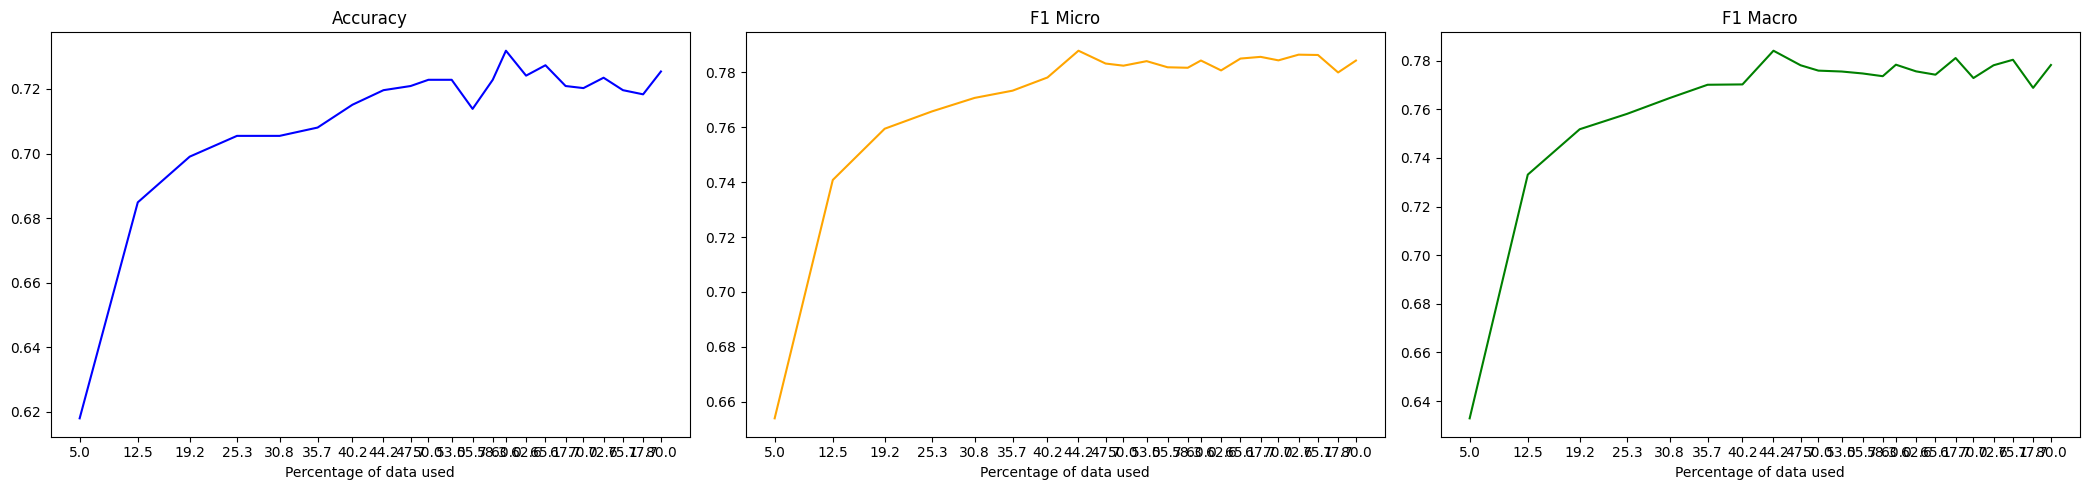

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.460827,0.440514,0.957447,0.033937,0.065550,0.044738
2,No log,0.398824,0.576849,0.872222,0.236802,0.372479,0.261927
3,No log,0.353225,0.591640,0.830054,0.349925,0.492308,0.420032
4,No log,0.330393,0.585852,0.775510,0.429864,0.553130,0.459224
5,No log,0.314286,0.593569,0.761511,0.486425,0.593649,0.525215
6,No log,0.306425,0.605145,0.788366,0.480392,0.597001,0.545943
7,No log,0.299625,0.612862,0.739634,0.578431,0.649175,0.610205
8,No log,0.297249,0.616720,0.771834,0.533183,0.630687,0.596109
9,No log,0.294833,0.624437,0.772004,0.549020,0.641692,0.603582
10,No log,0.295964,0.617363,0.774123,0.532428,0.630920,0.592582


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6128617363344051, F1 Micro: 0.649174777824799, F1 Macro: 0.6102054118583491
                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0023636298719793562
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 43.188647747039795 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.394753,0.544695,0.746647,0.377828,0.501753,0.442381
2,No log,0.312152,0.637942,0.771739,0.588989,0.668092,0.656634
3,No log,0.284362,0.664309,0.718615,0.751131,0.734513,0.725480
4,No log,0.266955,0.676527,0.750383,0.739065,0.744681,0.733060
5,No log,0.261938,0.679100,0.764182,0.711161,0.736719,0.723942
6,No log,0.259349,0.682958,0.777778,0.696833,0.735084,0.727175
7,No log,0.262174,0.687460,0.766254,0.746606,0.756303,0.747850
8,No log,0.268042,0.691961,0.760968,0.758673,0.759819,0.750443
9,0.289100,0.267012,0.688746,0.753383,0.755656,0.754518,0.747122
10,0.289100,0.265580,0.691318,0.769473,0.737557,0.753177,0.747164


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.73      0.74      0.73       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.76      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.42      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6919614147909968, F1 Micro: 0.7598187311178248, F1 Macro: 0.7504425230025057
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.73      0.74      0.73       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.76      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.42      0.42      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.004960259143263111
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 38.94581651687622 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.360506,0.563344,0.694577,0.550528,0.614220,0.599991
2,No log,0.291184,0.668167,0.760244,0.657617,0.705216,0.696254
3,No log,0.279365,0.659807,0.704197,0.797134,0.747789,0.743708
4,No log,0.255162,0.698392,0.764479,0.746606,0.755437,0.748749
5,No log,0.254998,0.694534,0.781276,0.711161,0.744572,0.736926
6,0.347200,0.260677,0.687460,0.774167,0.718703,0.745405,0.736133
7,0.347200,0.266670,0.688103,0.752438,0.756410,0.754419,0.747554
8,0.347200,0.269904,0.691318,0.755948,0.742836,0.749334,0.741645
9,0.347200,0.272734,0.692605,0.750563,0.753394,0.751976,0.744575
10,0.347200,0.270941,0.692605,0.756303,0.746606,0.751423,0.744334


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.72      0.77      0.75       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.76      0.75      0.76      1326
           macro avg       0.76      0.74      0.75      1326
        weighted avg       0.77      0.75      0.76      1326
         samples avg       0.42      0.41      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6983922829581993, F1 Micro: 0.7554368561617703, F1 Macro: 0.7487486937772516
                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.72      0.77      0.75       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.76      0.75      0.76      1326
           macro avg       0.76      0.74      0.75      1326
        weighted avg       0.77      0.75      0.76      1326
         samples avg       0.42      0.41      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.002403522562235595
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 35.05343985557556 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.341628,0.616720,0.699357,0.656109,0.677043,0.669571
2,No log,0.278748,0.679100,0.753521,0.726244,0.739631,0.726456
3,No log,0.253964,0.688103,0.786449,0.691554,0.735955,0.722378
4,No log,0.251845,0.704180,0.772836,0.733786,0.752805,0.747517
5,0.367100,0.253449,0.682315,0.762094,0.724736,0.742945,0.730647
6,0.367100,0.265106,0.690032,0.743719,0.781297,0.762045,0.755428
7,0.367100,0.266512,0.692605,0.751101,0.771493,0.761161,0.755057
8,0.367100,0.264874,0.695177,0.764209,0.750377,0.757230,0.751664
9,0.189000,0.271563,0.691318,0.763240,0.739065,0.750958,0.744470
10,0.189000,0.272585,0.695177,0.760337,0.748869,0.754559,0.748060


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.90      0.90       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.74      0.77      0.76      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.43      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.690032154340836, F1 Micro: 0.7620448694372931, F1 Macro: 0.7554280656743667
                      precision    recall  f1-score   support

          pornografi       0.89      0.90      0.90       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.74      0.77      0.76      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.43      0.44      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0036476409994065763
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 31.604849576950073 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.316243,0.598714,0.785714,0.497738,0.609418,0.591113
2,No log,0.264348,0.668167,0.787523,0.656863,0.716283,0.693122
3,No log,0.250348,0.683601,0.768686,0.736802,0.752407,0.744344
4,0.378100,0.250160,0.688103,0.781016,0.707391,0.742382,0.729113
5,0.378100,0.246363,0.702894,0.789602,0.733032,0.760266,0.750222
6,0.378100,0.258103,0.693891,0.769953,0.742081,0.755760,0.744100
7,0.205800,0.261600,0.711254,0.773900,0.769231,0.771558,0.765733
8,0.205800,0.267260,0.705466,0.767952,0.766214,0.767082,0.761656
9,0.205800,0.269351,0.709325,0.773002,0.773002,0.773002,0.769518
10,0.136500,0.269731,0.706109,0.780125,0.751885,0.765745,0.760511


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.69      0.67      0.68       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.73      0.71      0.72       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.43      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7093247588424437, F1 Micro: 0.7730015082956259, F1 Macro: 0.7695175937152525
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.69      0.67      0.68       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.73      0.71      0.72       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.43      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0037643912248313434
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 28.44988989830017 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.319828,0.634084,0.692565,0.779789,0.733593,0.729898
2,No log,0.255891,0.704823,0.768283,0.752640,0.760381,0.743869
3,0.386700,0.240001,0.705466,0.764264,0.767722,0.765989,0.756398
4,0.386700,0.237106,0.715756,0.788766,0.751885,0.769884,0.759303
5,0.386700,0.248506,0.714469,0.759942,0.792609,0.775932,0.770011
6,0.225900,0.249170,0.711897,0.786794,0.745852,0.765776,0.755667
7,0.225900,0.258309,0.709325,0.784082,0.750377,0.766859,0.759832
8,0.225900,0.264825,0.706109,0.782574,0.738311,0.759798,0.750613
9,0.146400,0.268392,0.711897,0.775401,0.765460,0.770398,0.763158
10,0.146400,0.272103,0.715113,0.775915,0.767722,0.771797,0.765413


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7144694533762058, F1 Micro: 0.7759320782576596, F1 Macro: 0.7700107428052048
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.44      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0018189940601587296
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 25.65479612350464 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.290923,0.635370,0.818807,0.538462,0.649682,0.618977
2,No log,0.247230,0.714469,0.780640,0.754148,0.767165,0.764129
3,0.380400,0.243571,0.699035,0.756116,0.769231,0.762617,0.753732
4,0.380400,0.237549,0.714469,0.778201,0.769985,0.774071,0.765548
5,0.380400,0.242048,0.715756,0.778452,0.773756,0.776097,0.768236
6,0.236300,0.252185,0.717685,0.776596,0.770739,0.773656,0.766976
7,0.236300,0.261662,0.710611,0.766099,0.780543,0.773254,0.766976
8,0.154800,0.266326,0.711897,0.771772,0.775264,0.773514,0.767246
9,0.154800,0.268410,0.708682,0.764228,0.779789,0.771930,0.763727
10,0.154800,0.271494,0.712540,0.767012,0.782051,0.774459,0.767966


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.77      0.80      0.78       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.77      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.77      0.78      1326
         samples avg       0.45      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7157556270096463, F1 Micro: 0.7760968229954615, F1 Macro: 0.7682364819623942
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.77      0.80      0.78       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.77      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.77      0.78      1326
         samples avg       0.45      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0012707347050309181
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 23.096931219100952 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.282626,0.666238,0.828933,0.592006,0.690717,0.679179
2,No log,0.244956,0.707395,0.802236,0.703620,0.749699,0.743935
3,0.381000,0.234929,0.720257,0.771812,0.780543,0.776153,0.770749
4,0.381000,0.238988,0.706752,0.786223,0.748869,0.767092,0.751704
5,0.240100,0.252846,0.711897,0.750173,0.815234,0.781352,0.777327
6,0.240100,0.255257,0.715113,0.760289,0.794118,0.776835,0.773098
7,0.165000,0.263124,0.720257,0.780469,0.777526,0.778995,0.776080
8,0.165000,0.271492,0.717685,0.792228,0.753394,0.772323,0.761547
9,0.165000,0.274100,0.718971,0.782041,0.768477,0.775200,0.768470
10,0.116700,0.279673,0.718971,0.774436,0.776772,0.775602,0.770418


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.92       362
                sara       0.63      0.71      0.67       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.69      0.81      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7118971061093248, F1 Micro: 0.7813516443801951, F1 Macro: 0.7773273457943826
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.92       362
                sara       0.63      0.71      0.67       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.69      0.81      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.000875266152434051
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 20.826843976974487 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274777,0.685531,0.749415,0.723982,0.736479,0.732566
2,No log,0.248439,0.692605,0.828767,0.638763,0.721465,0.698308
3,0.376400,0.234560,0.710611,0.752125,0.800905,0.775749,0.771938
4,0.376400,0.233009,0.717042,0.800000,0.751131,0.774796,0.760427
5,0.243100,0.239846,0.719614,0.773958,0.797888,0.785741,0.775710
6,0.243100,0.260365,0.718328,0.756852,0.812217,0.783558,0.777838
7,0.167900,0.255379,0.716399,0.778795,0.769985,0.774365,0.767504
8,0.167900,0.271264,0.715113,0.768607,0.786576,0.777488,0.769454
9,0.126600,0.273974,0.718328,0.776346,0.772247,0.774291,0.765855
10,0.126600,0.274235,0.718971,0.776853,0.774510,0.775680,0.768050


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.61      0.63       237
         radikalisme       0.76      0.83      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7196141479099678, F1 Micro: 0.785740809506127, F1 Macro: 0.7757099419845617
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.61      0.63       237
         radikalisme       0.76      0.83      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0004513358406256888
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 18.922720909118652 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266520,0.686174,0.800557,0.650830,0.717970,0.710341
2,No log,0.242445,0.711897,0.763716,0.787330,0.775343,0.766050
3,0.373100,0.228037,0.716399,0.779661,0.763198,0.771341,0.762410
4,0.373100,0.234834,0.722186,0.762040,0.811463,0.785975,0.780570
5,0.243600,0.237025,0.731190,0.786898,0.788084,0.787491,0.781297
6,0.243600,0.252683,0.727331,0.776952,0.788084,0.782478,0.775318
7,0.171000,0.262824,0.720257,0.766187,0.803167,0.784242,0.777723
8,0.171000,0.266052,0.722830,0.775056,0.787330,0.781145,0.774174
9,0.125000,0.268444,0.724759,0.790335,0.764706,0.777309,0.768665
10,0.125000,0.273589,0.724116,0.778947,0.781297,0.780120,0.772447


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.68      0.66      0.67       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7311897106109325, F1 Micro: 0.787490580256217, F1 Macro: 0.7812972080644348
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.68      0.66      0.67       237
         radikalisme       0.75      0.85      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0002832115977071226
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 17.55895233154297 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263065,0.684887,0.785411,0.698341,0.739321,0.726965
2,0.367800,0.236239,0.706109,0.802405,0.704374,0.750201,0.729886
3,0.367800,0.231391,0.715113,0.797678,0.725490,0.759874,0.749403
4,0.241900,0.229781,0.728617,0.790396,0.782051,0.786202,0.777157
5,0.241900,0.247670,0.718328,0.753653,0.816742,0.783931,0.777178
6,0.172100,0.255588,0.722830,0.782080,0.776772,0.779417,0.772939
7,0.172100,0.262360,0.727331,0.791091,0.776772,0.783866,0.776600
8,0.127200,0.272950,0.718971,0.771555,0.789593,0.780470,0.775496
9,0.127200,0.279586,0.718971,0.768444,0.793363,0.780705,0.774400
10,0.099600,0.279754,0.719614,0.776779,0.782051,0.779406,0.774472


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.70      0.61      0.65       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7286173633440515, F1 Micro: 0.7862016679302501, F1 Macro: 0.7771573031220365
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.70      0.61      0.65       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0002595329511677846
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 15.72869324684143 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263412,0.695820,0.759259,0.742081,0.750572,0.738062
2,0.361000,0.235258,0.711254,0.802226,0.706637,0.751403,0.743631
3,0.361000,0.227237,0.716399,0.808219,0.711916,0.757017,0.746062
4,0.241600,0.229515,0.724116,0.791766,0.754148,0.772499,0.761176
5,0.241600,0.238518,0.727974,0.809563,0.740573,0.773533,0.762238
6,0.173800,0.262110,0.717042,0.760979,0.797134,0.778637,0.770242
7,0.173800,0.270749,0.720257,0.759458,0.802413,0.780345,0.772192
8,0.127000,0.270395,0.729904,0.791217,0.774510,0.782774,0.775342
9,0.127000,0.287248,0.722186,0.763348,0.797888,0.780236,0.772977
10,0.099900,0.284515,0.726045,0.771787,0.788084,0.779851,0.773953


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.76      0.73      0.74       492

           micro avg       0.79      0.77      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.77      0.78      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.729903536977492, F1 Micro: 0.7827743902439024, F1 Macro: 0.7753416889410738
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.76      0.73      0.74       492

           micro avg       0.79      0.77      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.77      0.78      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 8.157326374202963e-05
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 14.197447299957275 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271003,0.670740,0.804926,0.616139,0.697992,0.660585
2,0.354900,0.237881,0.709968,0.786179,0.729261,0.756651,0.736202
3,0.354900,0.227963,0.720900,0.802469,0.735294,0.767414,0.753267
4,0.237000,0.237995,0.722186,0.752249,0.819759,0.784554,0.777435
5,0.237000,0.247047,0.722830,0.765759,0.806184,0.785452,0.776133
6,0.175000,0.258374,0.724759,0.772993,0.798643,0.785608,0.775557
7,0.175000,0.266120,0.721543,0.774336,0.791855,0.782998,0.778531
8,0.129200,0.272395,0.724116,0.781061,0.777526,0.779289,0.772386
9,0.100800,0.281986,0.722830,0.763233,0.804676,0.783407,0.776718
10,0.100800,0.282322,0.725402,0.775165,0.795626,0.785262,0.778691


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7247588424437299, F1 Micro: 0.7856083086053413, F1 Macro: 0.7755570657342689
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 9.9244339071447e-05
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 12.728227615356445 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258551,0.692605,0.762346,0.745098,0.753623,0.744959
2,0.351800,0.230169,0.708039,0.787611,0.738311,0.762164,0.748888
3,0.351800,0.224875,0.720257,0.794707,0.747360,0.770307,0.760275
4,0.238600,0.235932,0.723473,0.796975,0.754902,0.775368,0.764015
5,0.238600,0.247588,0.723473,0.771555,0.789593,0.780470,0.769846
6,0.174900,0.254170,0.724759,0.773792,0.797134,0.785290,0.777306
7,0.123700,0.262755,0.717685,0.782708,0.771493,0.777060,0.767589
8,0.123700,0.273396,0.726045,0.775570,0.794872,0.785102,0.778376
9,0.095900,0.284389,0.721543,0.773363,0.792609,0.782868,0.775962
10,0.095900,0.287605,0.723473,0.772394,0.793363,0.782738,0.775625


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7247588424437299, F1 Micro: 0.7852897473997028, F1 Macro: 0.777305685518708
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 4.929464776068931e-05
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 11.750552654266357 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251019,0.697106,0.758327,0.738311,0.748185,0.743801
2,0.345900,0.227838,0.718971,0.785328,0.766968,0.776040,0.765634
3,0.345900,0.225576,0.715113,0.814751,0.716440,0.762440,0.749896
4,0.233600,0.229261,0.711897,0.786552,0.758673,0.772361,0.758880
5,0.175400,0.243487,0.717685,0.764368,0.802413,0.782929,0.774301
6,0.175400,0.248101,0.717685,0.781557,0.779789,0.780672,0.773806
7,0.125800,0.258823,0.722830,0.796838,0.760181,0.778078,0.769356
8,0.125800,0.282630,0.714469,0.754545,0.813725,0.783019,0.778739
9,0.100600,0.283966,0.715113,0.767341,0.800905,0.783764,0.778772
10,0.077200,0.282898,0.718971,0.778439,0.789593,0.783976,0.778720


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7189710610932476, F1 Micro: 0.7839760389367278, F1 Macro: 0.7787195398519834
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 1.4783309961785574e-05
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 10.29879093170166 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249307,0.691961,0.810056,0.656109,0.725000,0.707526
2,0.338300,0.230873,0.717685,0.780315,0.747360,0.763482,0.760367
3,0.338300,0.227398,0.715113,0.783425,0.755656,0.769290,0.766955
4,0.234000,0.235710,0.730547,0.786371,0.774510,0.780395,0.773365
5,0.172500,0.238140,0.726688,0.774854,0.799397,0.786934,0.779039
6,0.172500,0.260329,0.720900,0.771066,0.779789,0.775403,0.766211
7,0.130000,0.266803,0.717685,0.772218,0.779789,0.775985,0.769220
8,0.100400,0.278990,0.720900,0.763939,0.795626,0.779461,0.771898
9,0.100400,0.281549,0.715756,0.771237,0.780543,0.775862,0.769407
10,0.082400,0.288923,0.724116,0.770818,0.788839,0.779724,0.773950


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.65      0.64      0.64       237
         radikalisme       0.76      0.86      0.81       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7266881028938906, F1 Micro: 0.7869339272457313, F1 Macro: 0.7790392975809395
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.65      0.64      0.64       237
         radikalisme       0.76      0.86      0.81       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 2.945139167422896e-05
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 8.720850944519043 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256154,0.679743,0.806113,0.636501,0.711336,0.700579
2,0.329700,0.235974,0.702251,0.834119,0.667421,0.741517,0.722915
3,0.329700,0.228782,0.720257,0.761632,0.802413,0.781491,0.772922
4,0.227800,0.244810,0.715113,0.747779,0.825038,0.784511,0.777317
5,0.169200,0.245304,0.726688,0.783233,0.782051,0.782642,0.777721
6,0.169200,0.262102,0.721543,0.761939,0.806184,0.783437,0.776017
7,0.128100,0.269638,0.727331,0.781297,0.781297,0.781297,0.771505
8,0.096400,0.283973,0.723473,0.777695,0.783560,0.780616,0.772996
9,0.096400,0.294798,0.719614,0.767374,0.791101,0.779057,0.772618
10,0.078100,0.295018,0.720900,0.772761,0.787330,0.779978,0.772883


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.69      0.84      0.76       492

           micro avg       0.75      0.83      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.715112540192926, F1 Micro: 0.7845105772678379, F1 Macro: 0.7773172148053569
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.69      0.84      0.76       492

           micro avg       0.75      0.83      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 4.200385665171781e-05
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 7.376342058181763 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260092,0.677170,0.824841,0.585973,0.685185,0.659756
2,0.326100,0.223091,0.717042,0.801495,0.727753,0.762846,0.749759
3,0.219700,0.221109,0.726045,0.803586,0.743590,0.772425,0.762274
4,0.219700,0.229485,0.722830,0.778366,0.776018,0.777190,0.767750
5,0.166400,0.237081,0.724759,0.784580,0.782805,0.783692,0.772838
6,0.129400,0.254131,0.724759,0.781627,0.782805,0.782216,0.774750
7,0.129400,0.265688,0.726045,0.801277,0.757164,0.778596,0.767662
8,0.095600,0.282283,0.724116,0.778029,0.779789,0.778908,0.771009
9,0.076600,0.287365,0.724116,0.777778,0.781297,0.779533,0.771194
10,0.076600,0.293603,0.724116,0.775130,0.785068,0.780067,0.772605


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.58      0.62       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7247588424437299, F1 Micro: 0.7836919592298981, F1 Macro: 0.7728379773014296
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.58      0.62       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.0256983478029717e-05
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 6.004159212112427 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240280,0.696463,0.781533,0.714932,0.746751,0.739770
2,0.321300,0.226818,0.715756,0.784223,0.764706,0.774341,0.761915
3,0.219800,0.223205,0.711254,0.775340,0.773002,0.774169,0.759514
4,0.219800,0.230893,0.725402,0.789755,0.779035,0.784358,0.772281
5,0.166600,0.245394,0.723473,0.768619,0.801659,0.784791,0.774150
6,0.122400,0.250339,0.718328,0.785004,0.773756,0.779339,0.769617
7,0.122400,0.271338,0.715756,0.773472,0.782805,0.778111,0.770015
8,0.095900,0.289593,0.715113,0.752949,0.818250,0.784243,0.776168
9,0.075100,0.287485,0.720900,0.773529,0.793363,0.783321,0.775321
10,0.064800,0.294700,0.724759,0.769732,0.801659,0.785371,0.778171


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7247588424437299, F1 Micro: 0.7853712596970818, F1 Macro: 0.7781710349156302
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 2.176238558604382e-06
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 4.531265735626221 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243194,0.698392,0.808394,0.668175,0.731627,0.711372
2,0.310600,0.234670,0.704180,0.736519,0.813725,0.773200,0.766818
3,0.212000,0.223305,0.718971,0.773998,0.772247,0.773122,0.762218
4,0.212000,0.233969,0.734405,0.786567,0.794872,0.790698,0.781380
5,0.165100,0.240513,0.726688,0.786202,0.782051,0.784121,0.773206
6,0.124100,0.262878,0.718328,0.753684,0.809955,0.780807,0.773903
7,0.094900,0.281528,0.713183,0.755889,0.798643,0.776678,0.769624
8,0.094900,0.285079,0.722186,0.778940,0.786576,0.782739,0.775120
9,0.076500,0.299115,0.715756,0.768275,0.792609,0.780252,0.773396
10,0.061600,0.301467,0.720900,0.768452,0.800905,0.784343,0.776444


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7344051446945338, F1 Micro: 0.7906976744186046, F1 Macro: 0.781380128236674
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 7.761515371385032e-06
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 3.0555014610290527 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241692,0.699035,0.800530,0.684012,0.737698,0.727896
2,0.301700,0.225635,0.709325,0.767669,0.769985,0.768825,0.759478
3,0.206700,0.223925,0.721543,0.778603,0.790347,0.784431,0.772716
4,0.160600,0.239137,0.713183,0.753715,0.803167,0.777656,0.768491
5,0.160600,0.242983,0.713826,0.789976,0.748869,0.768873,0.754914
6,0.120900,0.269746,0.715756,0.762248,0.797888,0.779661,0.771771
7,0.093800,0.267571,0.728617,0.792786,0.779035,0.785850,0.778381
8,0.076000,0.297680,0.715113,0.752268,0.812971,0.781443,0.777566
9,0.076000,0.294823,0.725402,0.774194,0.796380,0.785130,0.780286
10,0.061800,0.302018,0.720257,0.768169,0.797134,0.782383,0.776598


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.78      0.80      0.79       235
pencemaran_nama_baik       0.76      0.73      0.74       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7286173633440515, F1 Micro: 0.7858501331304679, F1 Macro: 0.7783807819363775
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.78      0.80      0.79       235
pencemaran_nama_baik       0.76      0.73      0.74       492

           micro avg       0.79      0.78      0.79      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.3562551885115684e-06
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.7022590637207031 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237551,0.705466,0.779200,0.734540,0.756211,0.746600
2,0.294800,0.218964,0.720257,0.789266,0.754148,0.771307,0.764185
3,0.202600,0.220005,0.722186,0.781157,0.794118,0.787584,0.774291
4,0.159100,0.234292,0.711254,0.773712,0.781297,0.777486,0.765277
5,0.159100,0.257346,0.722186,0.758693,0.822775,0.789436,0.780517
6,0.121900,0.265043,0.723473,0.788253,0.769231,0.778626,0.770445
7,0.092500,0.275489,0.721543,0.777444,0.779789,0.778614,0.769419
8,0.073800,0.293470,0.719614,0.775526,0.779035,0.777276,0.770183
9,0.059900,0.301912,0.721543,0.771852,0.785822,0.778774,0.772625
10,0.059900,0.306704,0.721543,0.773810,0.784314,0.779026,0.772765


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.76      0.83      0.80       235
pencemaran_nama_baik       0.73      0.81      0.77       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7221864951768489, F1 Micro: 0.7894356005788713, F1 Macro: 0.7805173721579128
                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.76      0.83      0.80       235
pencemaran_nama_baik       0.73      0.81      0.77       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.47      0.47      0.46      1326

Total sampling time: 379.4 seconds
Total runtime: 11602.418340682983 seconds


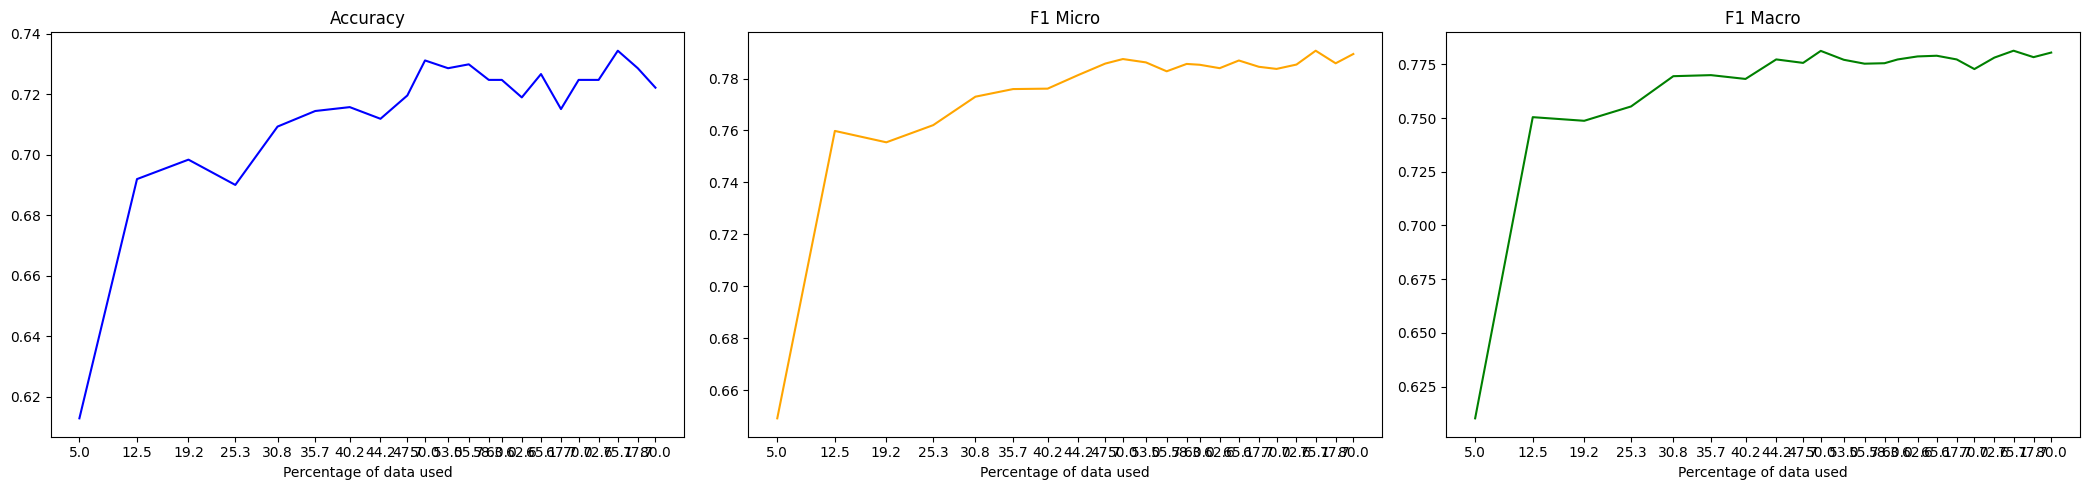

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.466312,0.447588,1.000000,0.012821,0.025316,0.022427
2,No log,0.392322,0.554984,0.920290,0.191554,0.317104,0.211713
3,No log,0.349551,0.584566,0.834646,0.319759,0.462377,0.381456
4,No log,0.331326,0.586495,0.799035,0.374811,0.510267,0.438305
5,No log,0.317812,0.590997,0.812303,0.388386,0.525510,0.465296
6,No log,0.312626,0.603859,0.802213,0.437406,0.566130,0.506563
7,No log,0.301693,0.610289,0.758030,0.533937,0.626549,0.600378
8,No log,0.300017,0.610932,0.759957,0.532428,0.626164,0.598342
9,No log,0.301048,0.610289,0.765419,0.524133,0.622202,0.587982
10,No log,0.300751,0.610289,0.768632,0.521116,0.621124,0.587391


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6102893890675242, F1 Micro: 0.6265486725663717, F1 Macro: 0.6003779383425171
                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.002649796381592751
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 43.25934314727783 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.401846,0.543408,0.810507,0.325792,0.464766,0.443674
2,No log,0.335444,0.571061,0.843806,0.354449,0.499203,0.439800
3,No log,0.288346,0.655949,0.784798,0.599548,0.679778,0.664004
4,No log,0.274632,0.665595,0.751252,0.678733,0.713154,0.703889
5,No log,0.271129,0.662379,0.768893,0.659879,0.710227,0.701775
6,No log,0.270576,0.667524,0.761628,0.691554,0.724901,0.716709
7,No log,0.275180,0.668810,0.759380,0.702112,0.729624,0.723697
8,No log,0.278518,0.673312,0.746501,0.723982,0.735069,0.730316
9,0.288900,0.276634,0.664952,0.761905,0.687783,0.722949,0.717162
10,0.288900,0.279137,0.664952,0.753659,0.699095,0.725352,0.719445


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.85      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.73      0.76      0.74       235
pencemaran_nama_baik       0.68      0.68      0.68       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.74      0.72      0.73      1326
        weighted avg       0.75      0.72      0.74      1326
         samples avg       0.40      0.40      0.39      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6733118971061093, F1 Micro: 0.7350689127105665, F1 Macro: 0.7303157837986083
                      precision    recall  f1-score   support

          pornografi       0.91      0.85      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.73      0.76      0.74       235
pencemaran_nama_baik       0.68      0.68      0.68       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.74      0.72      0.73      1326
        weighted avg       0.75      0.72      0.74      1326
         samples avg       0.40      0.40      0.39      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.005382639821618795
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 38.919211626052856 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.366467,0.564630,0.700382,0.553544,0.618366,0.614019
2,No log,0.304276,0.632154,0.774802,0.588989,0.669237,0.629820
3,No log,0.267855,0.676527,0.752739,0.725490,0.738863,0.730076
4,No log,0.263009,0.676527,0.744586,0.751885,0.748218,0.736141
5,No log,0.257556,0.678457,0.804945,0.662896,0.727047,0.711506
6,0.345200,0.260644,0.683601,0.753645,0.740573,0.747052,0.743786
7,0.345200,0.261032,0.682958,0.771036,0.718703,0.743950,0.735798
8,0.345200,0.266211,0.684244,0.764799,0.730769,0.747397,0.742150
9,0.345200,0.268555,0.687460,0.770716,0.722474,0.745815,0.737667
10,0.345200,0.270386,0.686817,0.769968,0.726998,0.747867,0.740912


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.68      0.51      0.58       237
         radikalisme       0.75      0.77      0.76       235
pencemaran_nama_baik       0.67      0.75      0.71       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.75      0.73      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.43      0.42      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6765273311897106, F1 Micro: 0.7482176360225141, F1 Macro: 0.7361408996065582
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.68      0.51      0.58       237
         radikalisme       0.75      0.77      0.76       235
pencemaran_nama_baik       0.67      0.75      0.71       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.75      0.73      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.43      0.42      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0026822858024388584
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 35.11684226989746 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.350694,0.572347,0.757030,0.507541,0.607675,0.596166
2,No log,0.288478,0.663666,0.758506,0.689291,0.722244,0.703022
3,No log,0.256175,0.691961,0.770505,0.736802,0.753277,0.744971
4,No log,0.270462,0.668810,0.710336,0.813725,0.758524,0.756823
5,0.373200,0.253824,0.697106,0.759522,0.766968,0.763227,0.759147
6,0.373200,0.256704,0.690675,0.796392,0.699095,0.744578,0.735477
7,0.373200,0.258289,0.701608,0.782470,0.740573,0.760945,0.757701
8,0.373200,0.262251,0.697106,0.766946,0.759427,0.763168,0.758591
9,0.193400,0.268066,0.697749,0.768582,0.756410,0.762448,0.758278
10,0.193400,0.267591,0.696463,0.770000,0.754902,0.762376,0.757568


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.70      0.71      0.71       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.76      0.77      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6971061093247588, F1 Micro: 0.7632270168855536, F1 Macro: 0.7591474285772731
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.70      0.71      0.71       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.76      0.77      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0028828650712966948
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 31.62633466720581 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.321511,0.605145,0.807692,0.490950,0.610694,0.598677
2,No log,0.266468,0.687460,0.759055,0.726998,0.742681,0.741380
3,No log,0.247119,0.689389,0.811808,0.663650,0.730290,0.715548
4,0.382800,0.246100,0.699678,0.806649,0.695324,0.746861,0.737420
5,0.382800,0.244678,0.703537,0.777778,0.749623,0.763441,0.759687
6,0.382800,0.252443,0.705466,0.770167,0.763198,0.766667,0.763581
7,0.208300,0.256504,0.709325,0.764402,0.780543,0.772388,0.769527
8,0.208300,0.262012,0.706752,0.763704,0.777526,0.770553,0.767525
9,0.208300,0.267392,0.708682,0.768821,0.762443,0.765619,0.758303
10,0.138900,0.265576,0.713183,0.777519,0.756410,0.766820,0.759002


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.72      0.73      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7093247588424437, F1 Micro: 0.7723880597014925, F1 Macro: 0.769527482139984
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.72      0.73      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.003223154786974196
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 28.4896240234375 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.316019,0.628296,0.776089,0.577677,0.662343,0.625237
2,No log,0.258053,0.700965,0.776167,0.726998,0.750779,0.745673
3,0.392400,0.251799,0.699678,0.740896,0.797888,0.768337,0.764980
4,0.392400,0.243646,0.703537,0.753060,0.788839,0.770534,0.764007
5,0.392400,0.248709,0.695820,0.740947,0.802413,0.770456,0.768597
6,0.234400,0.241508,0.713183,0.774510,0.774510,0.774510,0.770228
7,0.234400,0.251937,0.712540,0.778972,0.765460,0.772157,0.761951
8,0.234400,0.258108,0.704180,0.755991,0.785068,0.770255,0.764780
9,0.150800,0.262399,0.709968,0.770504,0.772247,0.771375,0.763038
10,0.150800,0.262898,0.711254,0.769288,0.774510,0.771890,0.764539


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.73      0.74      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.77      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7131832797427653, F1 Micro: 0.7745098039215687, F1 Macro: 0.770228286363165
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.73      0.74      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.78      0.77      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.00177869014441967
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 25.666548490524292 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.300945,0.609646,0.784205,0.531674,0.633708,0.602230
2,No log,0.254106,0.690032,0.780570,0.702866,0.739683,0.722504
3,0.388600,0.237228,0.712540,0.785542,0.737557,0.760793,0.748787
4,0.388600,0.243563,0.708039,0.744976,0.810709,0.776454,0.772465
5,0.388600,0.238171,0.708039,0.763930,0.785822,0.774721,0.768535
6,0.246900,0.244443,0.721543,0.796340,0.754902,0.775068,0.765968
7,0.246900,0.253047,0.718328,0.782542,0.770739,0.776596,0.771289
8,0.159300,0.257735,0.717685,0.798232,0.748869,0.772763,0.766381
9,0.159300,0.262352,0.714469,0.780488,0.772247,0.776346,0.771173
10,0.159300,0.266127,0.715113,0.776524,0.778281,0.777401,0.773022


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.77      0.85      0.80       235
pencemaran_nama_baik       0.73      0.72      0.72       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.715112540192926, F1 Micro: 0.777401129943503, F1 Macro: 0.7730216706884161
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.77      0.85      0.80       235
pencemaran_nama_baik       0.73      0.72      0.72       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0013196833315305412
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 22.880383729934692 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289789,0.672669,0.751403,0.706637,0.728333,0.715773
2,No log,0.247760,0.696463,0.782114,0.725490,0.752739,0.730178
3,0.387100,0.242740,0.707395,0.737526,0.813725,0.773754,0.769949
4,0.387100,0.229802,0.716399,0.814626,0.722474,0.765787,0.757157
5,0.243900,0.241691,0.719614,0.770696,0.793363,0.781865,0.776378
6,0.243900,0.243503,0.715113,0.801292,0.748115,0.773791,0.766139
7,0.171800,0.257375,0.711254,0.773414,0.772247,0.772830,0.767108
8,0.171800,0.265104,0.718971,0.770818,0.788839,0.779724,0.775657
9,0.171800,0.270044,0.715756,0.783474,0.772247,0.777820,0.770574
10,0.121000,0.269476,0.719614,0.787855,0.773002,0.780358,0.775712


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.68      0.66      0.67       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7196141479099678, F1 Micro: 0.7818654775176515, F1 Macro: 0.7763779516678719
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.68      0.66      0.67       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.000825527764391154
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 20.719524383544922 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.284227,0.664309,0.779174,0.654600,0.711475,0.689309
2,No log,0.250540,0.699678,0.778776,0.719457,0.747942,0.732069
3,0.384700,0.232922,0.708682,0.760838,0.794118,0.777122,0.770662
4,0.384700,0.225536,0.714469,0.780916,0.771493,0.776176,0.769441
5,0.249400,0.234403,0.717685,0.777194,0.781297,0.779240,0.773091
6,0.249400,0.241261,0.717042,0.773234,0.784314,0.778735,0.773876
7,0.173900,0.249783,0.725402,0.785986,0.778281,0.782114,0.772193
8,0.173900,0.257481,0.719614,0.787102,0.763952,0.775354,0.766918
9,0.128500,0.265923,0.721543,0.776952,0.788084,0.782478,0.774261
10,0.128500,0.266645,0.724116,0.776866,0.785068,0.780945,0.773521


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.68      0.63      0.65       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7215434083601286, F1 Micro: 0.7824784724822164, F1 Macro: 0.7742608436575753
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.68      0.63      0.65       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.00029403340304270416
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 18.729446172714233 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274818,0.662379,0.744240,0.730769,0.737443,0.726971
2,No log,0.241758,0.704823,0.772122,0.743590,0.757587,0.756391
3,0.378000,0.228915,0.720257,0.799028,0.743590,0.770312,0.759388
4,0.378000,0.227718,0.715756,0.797600,0.751885,0.774068,0.765671
5,0.246500,0.236853,0.722186,0.766691,0.805430,0.785583,0.778822
6,0.246500,0.244640,0.719614,0.790297,0.761689,0.775730,0.768067
7,0.173400,0.252738,0.721543,0.782510,0.776018,0.779250,0.769279
8,0.173400,0.263848,0.720257,0.769622,0.798643,0.783864,0.776965
9,0.125500,0.264705,0.726045,0.795455,0.765460,0.780169,0.774035
10,0.125500,0.268068,0.726688,0.785011,0.782051,0.783529,0.776677


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7221864951768489, F1 Micro: 0.7855829349025377, F1 Macro: 0.778821974768431
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00036072772636543967
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 17.31388282775879 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266737,0.687460,0.740105,0.747360,0.743715,0.739989
2,0.370900,0.237196,0.710611,0.778988,0.754902,0.766756,0.754127
3,0.370900,0.234381,0.700322,0.778219,0.738311,0.757740,0.745531
4,0.244400,0.237127,0.711897,0.764490,0.785822,0.775009,0.764782
5,0.244400,0.240275,0.711897,0.776006,0.770739,0.773364,0.764094
6,0.173100,0.248567,0.722186,0.796340,0.754902,0.775068,0.765630
7,0.173100,0.262625,0.717042,0.771577,0.782051,0.776779,0.770151
8,0.123500,0.276657,0.713183,0.763504,0.788839,0.775964,0.768846
9,0.123500,0.283199,0.712540,0.757358,0.795626,0.776021,0.770987
10,0.099300,0.278846,0.718328,0.773712,0.781297,0.777486,0.772008


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.66      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.73      0.73       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7183279742765273, F1 Micro: 0.777485928705441, F1 Macro: 0.7720083092903627
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.66      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.73      0.73       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0001093305050744675
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 15.596034288406372 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262977,0.691318,0.785838,0.686275,0.732689,0.720543
2,0.367800,0.231201,0.711254,0.766990,0.774510,0.770732,0.764668
3,0.367800,0.228580,0.711254,0.835945,0.684012,0.752385,0.735808
4,0.239200,0.230488,0.720900,0.833037,0.707391,0.765090,0.750409
5,0.239200,0.239745,0.726688,0.778932,0.791855,0.785340,0.777406
6,0.169700,0.245893,0.726045,0.798742,0.766214,0.782140,0.773826
7,0.169700,0.265372,0.726688,0.771866,0.798643,0.785026,0.776676
8,0.121200,0.265654,0.725402,0.790895,0.773002,0.781846,0.772278
9,0.121200,0.274148,0.725402,0.781764,0.788839,0.785285,0.776636
10,0.094300,0.275052,0.730547,0.786517,0.791855,0.789177,0.781932


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.77      0.84      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7305466237942122, F1 Micro: 0.7891770011273957, F1 Macro: 0.7819322562923477
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.77      0.84      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 4.8079117914312495e-05
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 14.07624077796936 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262296,0.691961,0.788360,0.674208,0.726829,0.721477
2,0.356000,0.238252,0.702894,0.764045,0.769231,0.766629,0.753771
3,0.356000,0.225712,0.710611,0.794286,0.733786,0.762838,0.750024
4,0.237900,0.241693,0.714469,0.751911,0.815988,0.782640,0.778248
5,0.237900,0.239658,0.720257,0.793538,0.759427,0.776108,0.768021
6,0.172400,0.252547,0.715113,0.792468,0.745852,0.768454,0.757100
7,0.172400,0.272458,0.722186,0.773529,0.793363,0.783321,0.776968
8,0.127200,0.278245,0.720900,0.764198,0.801659,0.782481,0.776373
9,0.098000,0.281528,0.720900,0.776053,0.791855,0.783875,0.776911
10,0.098000,0.283662,0.724759,0.779926,0.791101,0.785474,0.777586


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7247588424437299, F1 Micro: 0.7854736053912391, F1 Macro: 0.7775864614840142
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 2.94038638458005e-05
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 12.682311058044434 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252444,0.700965,0.761610,0.742081,0.751719,0.745570
2,0.350500,0.238810,0.713183,0.775809,0.759427,0.767530,0.755859
3,0.350500,0.240835,0.703537,0.738241,0.816742,0.775510,0.770211
4,0.228600,0.228585,0.727974,0.788636,0.785068,0.786848,0.776705
5,0.228600,0.236904,0.716399,0.772795,0.779789,0.776276,0.770894
6,0.174400,0.251015,0.719614,0.765557,0.797888,0.781388,0.774221
7,0.126100,0.263282,0.731190,0.773654,0.801659,0.787407,0.780706
8,0.126100,0.275247,0.718971,0.763989,0.803167,0.783088,0.775808
9,0.095200,0.276440,0.720900,0.775389,0.788839,0.782056,0.775773
10,0.095200,0.277639,0.720900,0.775223,0.788084,0.781601,0.774802


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7311897106109325, F1 Micro: 0.7874074074074074, F1 Macro: 0.7807057537247999
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 3.363400974194526e-05
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 11.67770791053772 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251835,0.700322,0.764196,0.730769,0.747109,0.736426
2,0.343900,0.235584,0.702251,0.814414,0.681750,0.742200,0.724978
3,0.343900,0.233059,0.716399,0.756565,0.803922,0.779525,0.773376
4,0.231400,0.230982,0.717685,0.776612,0.781297,0.778947,0.769702
5,0.172700,0.240886,0.720257,0.789961,0.771493,0.780618,0.772614
6,0.172700,0.247905,0.722830,0.791217,0.774510,0.782774,0.775595
7,0.123500,0.268745,0.728617,0.763840,0.822021,0.791863,0.785421
8,0.123500,0.269215,0.724116,0.784108,0.788839,0.786466,0.778413
9,0.096900,0.282650,0.722830,0.771137,0.797888,0.784285,0.778122
10,0.080700,0.281723,0.722186,0.773529,0.793363,0.783321,0.777240


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.65      0.71      0.68       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7286173633440515, F1 Micro: 0.7918634217217579, F1 Macro: 0.7854209311299433
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.65      0.71      0.68       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 3.3604213967919356e-05
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 10.167858123779297 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250093,0.679100,0.774167,0.700603,0.735550,0.713940
2,0.338200,0.228768,0.711254,0.795868,0.726244,0.759464,0.743904
3,0.338200,0.222326,0.714469,0.784329,0.762443,0.773231,0.767583
4,0.227500,0.231050,0.714469,0.772189,0.787330,0.779686,0.772330
5,0.169400,0.237944,0.718328,0.785332,0.775264,0.780266,0.771838
6,0.169400,0.255359,0.720257,0.791732,0.765460,0.778374,0.769008
7,0.123100,0.261871,0.727331,0.789275,0.788084,0.788679,0.781504
8,0.094000,0.279882,0.720900,0.767960,0.806184,0.786608,0.780333
9,0.094000,0.287904,0.724116,0.773888,0.800151,0.786800,0.782496
10,0.074600,0.286518,0.720900,0.784358,0.779035,0.781687,0.775366


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.68      0.65      0.67       237
         radikalisme       0.77      0.80      0.79       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.727331189710611, F1 Micro: 0.7886792452830188, F1 Macro: 0.7815044390709627
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.68      0.65      0.67       237
         radikalisme       0.77      0.80      0.79       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 9.862107435765233e-06
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 8.751190423965454 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.247969,0.695820,0.762490,0.748115,0.755234,0.741709
2,0.329500,0.227730,0.718328,0.768833,0.785068,0.776866,0.764046
3,0.329500,0.226575,0.724759,0.773091,0.801659,0.787116,0.777294
4,0.226400,0.231562,0.719614,0.765591,0.805430,0.785006,0.777110
5,0.163600,0.250601,0.724759,0.772794,0.792609,0.782576,0.773424
6,0.163600,0.260230,0.719614,0.763518,0.798643,0.780686,0.772075
7,0.124800,0.273795,0.722830,0.781846,0.773002,0.777399,0.771093
8,0.091500,0.282618,0.721543,0.772894,0.795626,0.784095,0.777468
9,0.091500,0.295617,0.722186,0.773460,0.795626,0.784387,0.777811
10,0.075700,0.293814,0.727331,0.781413,0.792609,0.786971,0.779512


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.74      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7247588424437299, F1 Micro: 0.787115883006294, F1 Macro: 0.7772941525796254
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.74      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 4.5198604493634785e-05
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 7.322348594665527 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258782,0.681672,0.708279,0.825792,0.762535,0.759636
2,0.322000,0.229621,0.706752,0.789909,0.720211,0.753452,0.748909
3,0.223900,0.227139,0.713183,0.774849,0.776018,0.775433,0.769713
4,0.223900,0.235383,0.717685,0.782344,0.775264,0.778788,0.769541
5,0.167800,0.242432,0.713183,0.790938,0.750377,0.770124,0.756059
6,0.127300,0.255961,0.721543,0.810544,0.742081,0.774803,0.761798
7,0.127300,0.284046,0.717042,0.757962,0.807692,0.782037,0.774766
8,0.093000,0.285642,0.724116,0.778853,0.788839,0.783814,0.775427
9,0.075100,0.289046,0.721543,0.782510,0.776018,0.779250,0.770878
10,0.075100,0.297460,0.722186,0.779940,0.785822,0.782870,0.776113


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7241157556270097, F1 Micro: 0.7838141626077183, F1 Macro: 0.7754272190947258
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 4.335823268775129e-06
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 5.992175340652466 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244937,0.687460,0.783531,0.696078,0.737220,0.730819
2,0.316900,0.223090,0.720900,0.777526,0.777526,0.777526,0.769568
3,0.218800,0.226365,0.711254,0.779938,0.756410,0.767994,0.761774
4,0.218800,0.235582,0.718328,0.786987,0.766214,0.776462,0.767528
5,0.165100,0.252004,0.720257,0.768284,0.800151,0.783894,0.779999
6,0.122300,0.270374,0.711254,0.757254,0.806938,0.781307,0.773975
7,0.122300,0.279146,0.713826,0.776765,0.771493,0.774120,0.767204
8,0.096000,0.287827,0.709325,0.772590,0.773756,0.773173,0.765389
9,0.074400,0.298858,0.716399,0.770757,0.791101,0.780796,0.774555
10,0.063800,0.301133,0.714469,0.767442,0.796380,0.781643,0.777328


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.63      0.71      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7202572347266881, F1 Micro: 0.7838936091614334, F1 Macro: 0.7799992253795074
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.63      0.71      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 5.798357597086578e-06
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 4.481413841247559 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241686,0.695820,0.771497,0.730769,0.750581,0.735593
2,0.306300,0.224271,0.717685,0.769970,0.785068,0.777446,0.768753
3,0.214600,0.236834,0.704823,0.729084,0.828054,0.775424,0.767980
4,0.214600,0.231116,0.736334,0.806147,0.771493,0.788439,0.777349
5,0.163500,0.237064,0.727974,0.812908,0.750377,0.780392,0.767917
6,0.120800,0.254776,0.725402,0.786787,0.790347,0.788563,0.779131
7,0.096000,0.275681,0.721543,0.775964,0.788839,0.782349,0.774395
8,0.096000,0.292749,0.718971,0.766215,0.810709,0.787834,0.782098
9,0.073100,0.297570,0.723473,0.770290,0.801659,0.785661,0.777996
10,0.059300,0.298902,0.726045,0.775256,0.798643,0.786776,0.778238


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.66      0.60      0.63       237
         radikalisme       0.78      0.83      0.81       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7254019292604501, F1 Micro: 0.7885628291948833, F1 Macro: 0.7791307897631552
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.66      0.60      0.63       237
         radikalisme       0.78      0.83      0.81       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 2.688477616175078e-06
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 3.05415940284729 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241347,0.699678,0.744236,0.779035,0.761238,0.755097
2,0.305400,0.244465,0.707395,0.720493,0.837858,0.774756,0.771790
3,0.205800,0.232686,0.717042,0.796583,0.738311,0.766341,0.755606
4,0.161300,0.239421,0.719614,0.761665,0.800151,0.780434,0.773492
5,0.161300,0.247603,0.718971,0.798737,0.763198,0.780563,0.768938
6,0.121600,0.267331,0.726688,0.770349,0.799397,0.784604,0.778472
7,0.090100,0.274838,0.722830,0.787414,0.773756,0.780525,0.771031
8,0.073000,0.298004,0.717042,0.781749,0.775264,0.778493,0.770077
9,0.073000,0.307439,0.720257,0.772627,0.791855,0.782123,0.775663
10,0.058900,0.309570,0.720257,0.771555,0.789593,0.780470,0.773108


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.67      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.45      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7266881028938906, F1 Micro: 0.7846039970392302, F1 Macro: 0.7784721049391167
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.67      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.45      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.9114851511403697e-06
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.6702980995178223 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248374,0.689389,0.845756,0.616139,0.712914,0.688868
2,0.296200,0.228043,0.713183,0.750000,0.805430,0.776727,0.769257
3,0.201800,0.232241,0.715756,0.738781,0.831825,0.782547,0.777184
4,0.160500,0.231086,0.726688,0.781955,0.784314,0.783133,0.775400
5,0.160500,0.251731,0.721543,0.762074,0.809201,0.784931,0.777074
6,0.120900,0.265391,0.722830,0.780543,0.780543,0.780543,0.774339
7,0.092800,0.273217,0.727331,0.803543,0.752640,0.777259,0.767500
8,0.072000,0.288632,0.722186,0.778529,0.782051,0.780286,0.773537
9,0.058800,0.306937,0.717042,0.757426,0.807692,0.781752,0.774900
10,0.058800,0.302274,0.721543,0.776532,0.783560,0.780030,0.772537


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.72      0.79      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7215434083601286, F1 Micro: 0.784930504754938, F1 Macro: 0.7770739820900597
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.72      0.79      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 378.19 seconds
Total runtime: 11467.06394481659 seconds


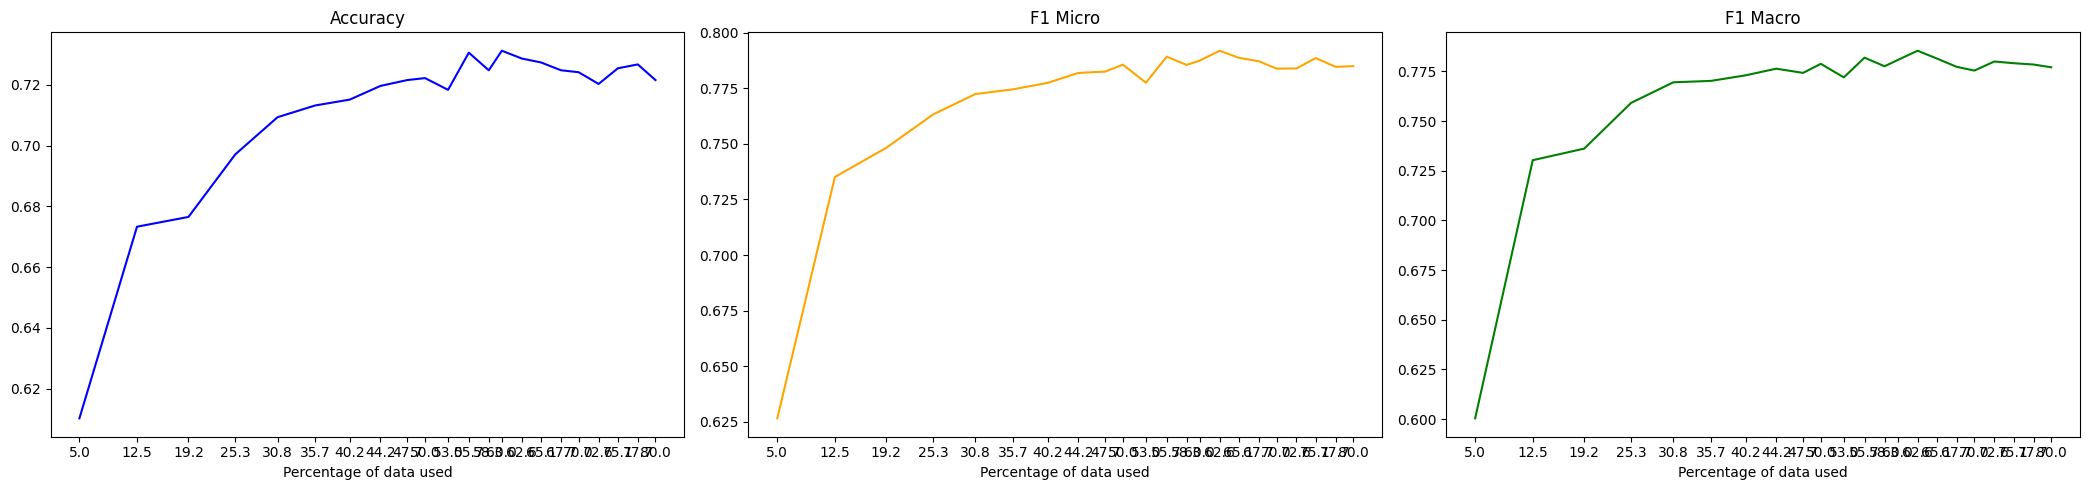

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241222_142614-w7l031ps
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-mc-4
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.463594,0.462379,0.975610,0.030166,0.058522,0.049751
2,No log,0.391793,0.568489,0.831081,0.278281,0.416949,0.340929
3,No log,0.357158,0.562701,0.873684,0.250377,0.389215,0.305181
4,No log,0.331397,0.590354,0.783858,0.432127,0.557122,0.487882
5,No log,0.317543,0.603215,0.790637,0.458522,0.580430,0.516101
6,No log,0.307228,0.619293,0.780571,0.515083,0.620627,0.590389
7,No log,0.304412,0.622508,0.775442,0.528658,0.628700,0.586116
8,No log,0.301726,0.622508,0.763407,0.547511,0.637681,0.605725
9,No log,0.302151,0.625723,0.764644,0.551282,0.640666,0.610989
10,No log,0.300772,0.628939,0.751984,0.571644,0.649529,0.626356


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6289389067524116, F1 Micro: 0.6495287060839761, F1 Macro: 0.626355645176144
                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.003258097870275382
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 42.63621258735657 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.393320,0.578135,0.813592,0.315988,0.455187,0.363160
2,No log,0.320124,0.606431,0.825352,0.441931,0.575639,0.532272
3,No log,0.284241,0.654662,0.788650,0.607843,0.686542,0.667491
4,No log,0.271769,0.664309,0.768486,0.658371,0.709180,0.696748
5,No log,0.274218,0.670740,0.759046,0.696078,0.726200,0.713626
6,No log,0.269784,0.679100,0.797468,0.665158,0.725329,0.711193
7,No log,0.273490,0.681029,0.799443,0.649321,0.716604,0.702167
8,No log,0.275738,0.673312,0.756000,0.712670,0.733696,0.724812
9,0.305400,0.273213,0.688746,0.786449,0.691554,0.735955,0.728033
10,0.305400,0.275060,0.685531,0.786022,0.687029,0.733199,0.724803


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.83      0.88       362
                sara       0.70      0.55      0.61       237
         radikalisme       0.75      0.72      0.73       235
pencemaran_nama_baik       0.74      0.64      0.69       492

           micro avg       0.79      0.69      0.74      1326
           macro avg       0.78      0.69      0.73      1326
        weighted avg       0.78      0.69      0.73      1326
         samples avg       0.39      0.39      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6887459807073955, F1 Micro: 0.7359550561797753, F1 Macro: 0.7280334269266118
                      precision    recall  f1-score   support

          pornografi       0.92      0.83      0.88       362
                sara       0.70      0.55      0.61       237
         radikalisme       0.75      0.72      0.73       235
pencemaran_nama_baik       0.74      0.64      0.69       492

           micro avg       0.79      0.69      0.74      1326
           macro avg       0.78      0.69      0.73      1326
        weighted avg       0.78      0.69      0.73      1326
         samples avg       0.39      0.39      0.38      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.004801036417484285
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 38.44659185409546 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.355195,0.571061,0.765568,0.472851,0.584615,0.580131
2,No log,0.294770,0.649518,0.784661,0.601810,0.681178,0.671248
3,No log,0.266388,0.691318,0.773849,0.709653,0.740362,0.730483
4,No log,0.256333,0.685531,0.800000,0.669683,0.729064,0.715989
5,No log,0.256766,0.698392,0.793939,0.691554,0.739218,0.732190
6,0.354500,0.261408,0.695177,0.776500,0.712670,0.743217,0.737718
7,0.354500,0.260898,0.698392,0.782430,0.718703,0.749214,0.739316
8,0.354500,0.269244,0.696463,0.778682,0.721719,0.749119,0.741263
9,0.354500,0.267458,0.695820,0.779592,0.720211,0.748726,0.740549
10,0.354500,0.269810,0.693891,0.782465,0.713424,0.746351,0.737831


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.86      0.89       362
                sara       0.69      0.55      0.61       237
         radikalisme       0.73      0.77      0.75       235
pencemaran_nama_baik       0.75      0.67      0.71       492

           micro avg       0.78      0.72      0.75      1326
           macro avg       0.77      0.71      0.74      1326
        weighted avg       0.78      0.72      0.75      1326
         samples avg       0.41      0.40      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6983922829581993, F1 Micro: 0.7492138364779874, F1 Macro: 0.7393164423073333
                      precision    recall  f1-score   support

          pornografi       0.91      0.86      0.89       362
                sara       0.69      0.55      0.61       237
         radikalisme       0.73      0.77      0.75       235
pencemaran_nama_baik       0.75      0.67      0.71       492

           micro avg       0.78      0.72      0.75      1326
           macro avg       0.77      0.71      0.74      1326
        weighted avg       0.78      0.72      0.75      1326
         samples avg       0.41      0.40      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0042204767931252754
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 34.659520864486694 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.350931,0.551125,0.660741,0.672700,0.666667,0.660653
2,No log,0.280679,0.673955,0.775493,0.682504,0.726033,0.709343
3,No log,0.255332,0.702894,0.783182,0.716440,0.748326,0.739424
4,No log,0.250572,0.700965,0.773555,0.736802,0.754732,0.747824
5,0.384700,0.251539,0.700965,0.781863,0.721719,0.750588,0.739344
6,0.384700,0.258395,0.704180,0.812444,0.689291,0.745818,0.732774
7,0.384700,0.256937,0.703537,0.795130,0.714178,0.752483,0.744707
8,0.384700,0.265222,0.705466,0.795262,0.708899,0.749601,0.740041
9,0.200000,0.271837,0.705466,0.779023,0.733786,0.755728,0.747605
10,0.200000,0.271042,0.703537,0.785016,0.726998,0.754894,0.748443


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.68      0.56      0.62       237
         radikalisme       0.74      0.80      0.77       235
pencemaran_nama_baik       0.73      0.67      0.70       492

           micro avg       0.78      0.73      0.76      1326
           macro avg       0.77      0.73      0.75      1326
        weighted avg       0.78      0.73      0.75      1326
         samples avg       0.42      0.41      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.7054662379421222, F1 Micro: 0.7557281553398058, F1 Macro: 0.7476045247385581
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.68      0.56      0.62       237
         radikalisme       0.74      0.80      0.77       235
pencemaran_nama_baik       0.73      0.67      0.70       492

           micro avg       0.78      0.73      0.76      1326
           macro avg       0.77      0.73      0.75      1326
        weighted avg       0.78      0.73      0.75      1326
         samples avg       0.42      0.41      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.003375271242111922
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 31.188051223754883 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.329938,0.583923,0.679160,0.683258,0.681203,0.679583
2,No log,0.266333,0.689389,0.795556,0.674962,0.730314,0.721450
3,No log,0.244125,0.708039,0.788003,0.723228,0.754227,0.743792
4,0.387800,0.240491,0.708682,0.789819,0.725490,0.756289,0.746676
5,0.387800,0.246403,0.707395,0.796327,0.719457,0.755943,0.750561
6,0.387800,0.250973,0.714469,0.806368,0.706637,0.753215,0.744916
7,0.220600,0.257275,0.713183,0.783570,0.748115,0.765432,0.758301
8,0.220600,0.262434,0.716399,0.780715,0.757164,0.768760,0.759534
9,0.220600,0.264534,0.715756,0.798195,0.733786,0.764637,0.756876
10,0.149200,0.266918,0.714469,0.784640,0.747360,0.765547,0.758294


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.90       362
                sara       0.68      0.57      0.62       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.74      0.72      0.73       492

           micro avg       0.78      0.76      0.77      1326
           macro avg       0.77      0.75      0.76      1326
        weighted avg       0.78      0.76      0.77      1326
         samples avg       0.44      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7163987138263666, F1 Micro: 0.7687595712098009, F1 Macro: 0.7595343819886143
                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.90       362
                sara       0.68      0.57      0.62       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.74      0.72      0.73       492

           micro avg       0.78      0.76      0.77      1326
           macro avg       0.77      0.75      0.76      1326
        weighted avg       0.78      0.76      0.77      1326
         samples avg       0.44      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0026530363131314514
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 28.17506432533264 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.312185,0.641801,0.742834,0.684012,0.712210,0.699933
2,No log,0.256220,0.698392,0.759822,0.773002,0.766355,0.759818
3,0.388200,0.241103,0.713183,0.777609,0.769985,0.773778,0.767124
4,0.388200,0.238192,0.712540,0.792271,0.742081,0.766355,0.759050
5,0.388200,0.240199,0.707395,0.808456,0.706637,0.754125,0.737838
6,0.231400,0.247020,0.716399,0.807047,0.725490,0.764098,0.755999
7,0.231400,0.258695,0.720900,0.770132,0.793363,0.781575,0.775991
8,0.231400,0.261166,0.713183,0.774096,0.775264,0.774680,0.767323
9,0.157500,0.265413,0.718328,0.777104,0.773002,0.775047,0.766627
10,0.157500,0.267597,0.722186,0.774606,0.777526,0.776063,0.768632


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7209003215434083, F1 Micro: 0.7815750371471024, F1 Macro: 0.7759907597120708
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.00169987918343395
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 25.360082149505615 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.292959,0.667524,0.758590,0.649321,0.699716,0.700099
2,No log,0.249490,0.693891,0.802867,0.675716,0.733825,0.721602
3,0.385500,0.238880,0.715756,0.763464,0.791101,0.777037,0.773221
4,0.385500,0.234604,0.720900,0.779357,0.785822,0.782576,0.774268
5,0.385500,0.235389,0.722830,0.784463,0.776772,0.780599,0.772018
6,0.244500,0.247423,0.717042,0.805099,0.738311,0.770260,0.761087
7,0.244500,0.250698,0.721543,0.795400,0.756410,0.775416,0.766035
8,0.164200,0.262064,0.718971,0.786105,0.759427,0.772535,0.767392
9,0.164200,0.264190,0.718971,0.788776,0.763198,0.775776,0.769297
10,0.164200,0.267255,0.720257,0.773065,0.783560,0.778277,0.773972


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.68      0.63      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7209003215434083, F1 Micro: 0.7825760420578295, F1 Macro: 0.7742676299727903
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.68      0.63      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0010258442489430308
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 22.85179352760315 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.285629,0.654019,0.796829,0.606335,0.688651,0.681516
2,No log,0.243789,0.703537,0.794093,0.709653,0.749502,0.738096
3,0.384500,0.231883,0.706109,0.803787,0.704374,0.750804,0.739224
4,0.384500,0.236938,0.719614,0.753613,0.825792,0.788053,0.780901
5,0.250300,0.234589,0.718971,0.783908,0.771493,0.777651,0.767172
6,0.250300,0.243836,0.728617,0.784897,0.776018,0.780432,0.770630
7,0.173600,0.249409,0.722186,0.786708,0.767722,0.777099,0.768273
8,0.173600,0.251537,0.720257,0.777361,0.782051,0.779699,0.772135
9,0.173600,0.259557,0.723473,0.786378,0.766214,0.776165,0.767619
10,0.125900,0.261898,0.726688,0.784848,0.781297,0.783069,0.776965


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.73      0.81      0.77       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7196141479099678, F1 Micro: 0.7880532565671104, F1 Macro: 0.7809011453327289
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.73      0.81      0.77       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0009325450519099832
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 20.599200963974 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274535,0.668810,0.800391,0.616893,0.696763,0.670383
2,No log,0.246330,0.697749,0.806625,0.679487,0.737618,0.721940
3,0.377900,0.230601,0.708682,0.794702,0.723982,0.757695,0.744669
4,0.377900,0.229243,0.722186,0.784781,0.769985,0.777313,0.769532
5,0.244600,0.231020,0.720257,0.790845,0.755656,0.772850,0.762870
6,0.244600,0.244037,0.720900,0.779123,0.776772,0.777946,0.770093
7,0.175800,0.251165,0.717042,0.786212,0.765460,0.775697,0.768661
8,0.175800,0.259003,0.719614,0.790461,0.762443,0.776200,0.767866
9,0.122500,0.267954,0.718971,0.770588,0.790347,0.780343,0.776227
10,0.122500,0.268875,0.717685,0.773134,0.781297,0.777194,0.771545


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.66      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7189710610932476, F1 Micro: 0.7803425167535368, F1 Macro: 0.7762267191674295
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.66      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.00030444273143075454
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 18.637320518493652 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.267492,0.688746,0.791923,0.680241,0.731846,0.725494
2,No log,0.234885,0.717042,0.778462,0.763198,0.770754,0.761515
3,0.375300,0.239936,0.714469,0.751067,0.796380,0.773060,0.769430
4,0.375300,0.233251,0.717042,0.799174,0.729261,0.762618,0.757762
5,0.244200,0.243962,0.717685,0.749826,0.813725,0.780470,0.774883
6,0.244200,0.246056,0.724116,0.771429,0.794118,0.782609,0.776731
7,0.173800,0.249728,0.724759,0.778534,0.776772,0.777652,0.769512
8,0.173800,0.270287,0.724116,0.758790,0.813725,0.785298,0.780213
9,0.129500,0.274649,0.725402,0.765299,0.801659,0.783057,0.777472
10,0.129500,0.271684,0.725402,0.774074,0.788084,0.781016,0.775193


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7241157556270097, F1 Micro: 0.7852983988355168, F1 Macro: 0.7802130540660148
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00027628550305962583
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 17.257524967193604 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.268493,0.691961,0.747727,0.744344,0.746032,0.744013
2,0.368200,0.233021,0.713826,0.779701,0.747360,0.763188,0.757145
3,0.368200,0.232219,0.707395,0.803404,0.711916,0.754898,0.745381
4,0.244000,0.232924,0.726045,0.773766,0.791855,0.782706,0.773437
5,0.244000,0.244292,0.722830,0.769062,0.791101,0.779926,0.770637
6,0.176600,0.243199,0.729260,0.784358,0.779035,0.781687,0.771842
7,0.176600,0.259166,0.727974,0.799523,0.757919,0.778165,0.768453
8,0.127300,0.271280,0.731190,0.766094,0.807692,0.786344,0.780665
9,0.127300,0.272764,0.727974,0.776053,0.791855,0.783875,0.778025
10,0.102000,0.277078,0.723473,0.772189,0.787330,0.779686,0.772476


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7311897106109325, F1 Micro: 0.7863436123348018, F1 Macro: 0.7806649816228883
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.73      0.78      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0001234992145327851
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 15.552795648574829 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.265850,0.672026,0.809100,0.616893,0.700043,0.691838
2,0.364100,0.236543,0.712540,0.767407,0.781297,0.774290,0.769032
3,0.364100,0.224267,0.723473,0.773739,0.786576,0.780105,0.771894
4,0.243400,0.238763,0.715756,0.770649,0.788084,0.779269,0.770447
5,0.243400,0.230444,0.722186,0.789069,0.773002,0.780952,0.770579
6,0.179400,0.251480,0.720900,0.759233,0.806184,0.782004,0.773985
7,0.179400,0.253448,0.729904,0.770338,0.806938,0.788214,0.783848
8,0.131800,0.262037,0.723473,0.769899,0.802413,0.785820,0.777868
9,0.131800,0.272072,0.722186,0.762894,0.803167,0.782513,0.773892
10,0.104900,0.270260,0.722830,0.770941,0.784314,0.777570,0.770180


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.729903536977492, F1 Micro: 0.7882136279926336, F1 Macro: 0.7838482451932203
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 7.186958464444614e-05
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 14.041863679885864 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256112,0.700322,0.781955,0.705882,0.741974,0.733774
2,0.354000,0.230410,0.711254,0.790507,0.728507,0.758242,0.750008
3,0.354000,0.223917,0.729904,0.773517,0.806184,0.789513,0.782450
4,0.236100,0.235155,0.708039,0.749471,0.800905,0.774335,0.767416
5,0.236100,0.234272,0.731833,0.782836,0.791101,0.786947,0.780504
6,0.176000,0.257729,0.717042,0.753492,0.813725,0.782451,0.775564
7,0.176000,0.260359,0.724759,0.771408,0.801659,0.786243,0.780695
8,0.126100,0.270004,0.724116,0.777778,0.776018,0.776897,0.768879
9,0.097600,0.274341,0.721543,0.780061,0.773002,0.776515,0.770139
10,0.097600,0.276553,0.718328,0.774584,0.772247,0.773414,0.767463


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.68      0.68      0.68       237
         radikalisme       0.76      0.80      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.729903536977492, F1 Micro: 0.7895125553914327, F1 Macro: 0.7824500439710769
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.68      0.68      0.68       237
         radikalisme       0.76      0.80      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00017884326080093153
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 12.670927286148071 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.255779,0.699035,0.781638,0.712670,0.745562,0.730115
2,0.352400,0.232453,0.715113,0.778462,0.763198,0.770754,0.756324
3,0.352400,0.224102,0.726045,0.785714,0.771493,0.778539,0.769633
4,0.239400,0.234501,0.724116,0.757429,0.826546,0.790480,0.784538
5,0.239400,0.239941,0.728617,0.771904,0.803922,0.787588,0.780496
6,0.179800,0.243333,0.728617,0.788593,0.782051,0.785309,0.774578
7,0.133100,0.262594,0.730547,0.766548,0.812217,0.788722,0.782688
8,0.133100,0.268635,0.723473,0.767459,0.803922,0.785267,0.781364
9,0.100700,0.272924,0.720900,0.773060,0.796380,0.784547,0.779681
10,0.100700,0.277119,0.722830,0.773932,0.792609,0.783159,0.777974


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.71      0.66       237
         radikalisme       0.74      0.87      0.80       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.76      0.83      0.79      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7241157556270097, F1 Micro: 0.7904796249549224, F1 Macro: 0.7845379125488983
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.71      0.66       237
         radikalisme       0.74      0.87      0.80       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.76      0.83      0.79      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 0.00010263406002195563
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 11.5855393409729 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262179,0.677170,0.752680,0.741327,0.746960,0.721665
2,0.344800,0.226590,0.719614,0.783048,0.759427,0.771057,0.766277
3,0.344800,0.228536,0.720257,0.764792,0.789593,0.776994,0.771082
4,0.234100,0.248513,0.715113,0.751223,0.810709,0.779833,0.772675
5,0.177200,0.237660,0.728617,0.786787,0.790347,0.788563,0.780191
6,0.177200,0.248137,0.726045,0.784791,0.778281,0.781522,0.777485
7,0.129700,0.254591,0.725402,0.806295,0.753394,0.778947,0.771487
8,0.129700,0.272199,0.724116,0.776208,0.787330,0.781730,0.776179
9,0.102100,0.279455,0.726688,0.778609,0.785068,0.781825,0.776117
10,0.082300,0.286825,0.725402,0.772993,0.798643,0.785608,0.780146


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7286173633440515, F1 Micro: 0.7885628291948833, F1 Macro: 0.7801914831002827
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.67      0.61      0.64       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 3.536934964358809e-05
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 10.171801567077637 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249396,0.694534,0.786325,0.693816,0.737179,0.727459
2,0.338000,0.229005,0.713183,0.761043,0.792609,0.776505,0.767132
3,0.338000,0.223879,0.713826,0.786846,0.748869,0.767388,0.756712
4,0.232800,0.234902,0.724759,0.794002,0.758673,0.775935,0.766362
5,0.170300,0.243946,0.721543,0.776276,0.779789,0.778029,0.772448
6,0.170300,0.265706,0.711254,0.744235,0.803167,0.772579,0.766155
7,0.128400,0.275895,0.725402,0.766667,0.797888,0.781966,0.774216
8,0.094200,0.285387,0.721543,0.768782,0.794872,0.781609,0.776205
9,0.094200,0.289828,0.725402,0.780433,0.788084,0.784240,0.776605
10,0.079100,0.292350,0.723473,0.771093,0.792609,0.781703,0.774813


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.75      0.84      0.80       235
pencemaran_nama_baik       0.74      0.75      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7254019292604501, F1 Micro: 0.7842401500938087, F1 Macro: 0.7766052206817713
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.75      0.84      0.80       235
pencemaran_nama_baik       0.74      0.75      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.46      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 7.215645382530059e-06
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 8.746212482452393 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245443,0.700322,0.778589,0.723982,0.750293,0.732426
2,0.331900,0.231220,0.700322,0.805604,0.693816,0.745543,0.741349
3,0.331900,0.237396,0.710611,0.733555,0.832579,0.779936,0.776129
4,0.226500,0.238642,0.725402,0.761735,0.807692,0.784041,0.777451
5,0.167400,0.237165,0.722186,0.790210,0.766968,0.778416,0.769991
6,0.167400,0.258395,0.726045,0.771304,0.798643,0.784735,0.777530
7,0.127600,0.264410,0.731190,0.784580,0.782805,0.783692,0.777835
8,0.095700,0.280947,0.723473,0.787809,0.769985,0.778795,0.772902
9,0.095700,0.288363,0.726688,0.781392,0.779035,0.780211,0.774004
10,0.077200,0.295871,0.724759,0.770015,0.797888,0.783704,0.778171


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7260450160771704, F1 Micro: 0.784735087069285, F1 Macro: 0.7775303603379391
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.75      0.81      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 8.408731810050086e-06
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 7.352232933044434 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244210,0.696463,0.787573,0.707391,0.745332,0.729785
2,0.323900,0.222479,0.713826,0.803691,0.722474,0.760921,0.747130
3,0.224400,0.228974,0.711254,0.740242,0.829563,0.782361,0.775881
4,0.224400,0.229184,0.720900,0.779367,0.780543,0.779955,0.772699
5,0.168800,0.253041,0.718971,0.744870,0.821267,0.781205,0.774960
6,0.128900,0.253662,0.729260,0.780578,0.794118,0.787290,0.780633
7,0.128900,0.270348,0.724759,0.778523,0.787330,0.782902,0.771968
8,0.095900,0.277645,0.723473,0.775570,0.794872,0.785102,0.780214
9,0.075600,0.287532,0.713826,0.760462,0.794872,0.777286,0.770814
10,0.075600,0.293972,0.713826,0.764663,0.796380,0.780199,0.774909


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7292604501607717, F1 Micro: 0.7872897196261682, F1 Macro: 0.7806328707680644
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 5.083678297523874e-06
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 5.937952041625977 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243474,0.704180,0.759287,0.770739,0.764970,0.754986
2,0.312400,0.226080,0.718971,0.760870,0.791855,0.776053,0.771855
3,0.218900,0.235770,0.713826,0.742857,0.823529,0.781116,0.777520
4,0.218900,0.231638,0.724116,0.787451,0.757164,0.772011,0.767582
5,0.166400,0.251630,0.722186,0.744139,0.837858,0.788223,0.783895
6,0.130200,0.253232,0.738264,0.804107,0.767722,0.785494,0.774507
7,0.130200,0.267643,0.719614,0.768727,0.797134,0.782673,0.778728
8,0.098800,0.291770,0.729260,0.761804,0.815234,0.787614,0.783623
9,0.078100,0.290033,0.733119,0.778846,0.794118,0.786408,0.780290
10,0.066800,0.294652,0.729904,0.773818,0.802413,0.787856,0.782715


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.47      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7221864951768489, F1 Micro: 0.7882227740333452, F1 Macro: 0.7838951366116051
                      precision    recall  f1-score   support

          pornografi       0.91      0.93      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.69      0.82      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.47      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 7.5129848482902155e-06
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 4.501275539398193 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241169,0.690032,0.787361,0.695324,0.738486,0.722506
2,0.309900,0.226472,0.710611,0.750532,0.798643,0.773840,0.768485
3,0.215600,0.230116,0.723473,0.768231,0.802413,0.784950,0.776813
4,0.215600,0.242649,0.717042,0.749134,0.815234,0.780787,0.778267
5,0.166100,0.250743,0.715756,0.755102,0.809201,0.781216,0.776111
6,0.125200,0.262821,0.726688,0.774834,0.794118,0.784358,0.776219
7,0.098200,0.274547,0.721543,0.777778,0.776018,0.776897,0.766481
8,0.098200,0.293748,0.720900,0.758133,0.808446,0.782482,0.777277
9,0.077000,0.300775,0.718328,0.755289,0.807692,0.780612,0.775719
10,0.065700,0.297912,0.719614,0.772794,0.792609,0.782576,0.774758


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7234726688102894, F1 Micro: 0.7849502028771672, F1 Macro: 0.776813016002606
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.7789124103728682e-05
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 3.1178781986236572 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240692,0.693248,0.748364,0.776018,0.761940,0.751971
2,0.305500,0.227109,0.706752,0.821109,0.692308,0.751227,0.736457
3,0.209600,0.231777,0.721543,0.756833,0.814480,0.784599,0.780086
4,0.163500,0.227701,0.728617,0.790930,0.776018,0.783403,0.772769
5,0.163500,0.253035,0.720900,0.754888,0.815234,0.783901,0.774456
6,0.124300,0.266052,0.725402,0.763456,0.812971,0.787436,0.783318
7,0.096700,0.274796,0.723473,0.777194,0.781297,0.779240,0.771620
8,0.075900,0.276722,0.729260,0.795597,0.763198,0.779061,0.769911
9,0.075900,0.296019,0.723473,0.773065,0.783560,0.778277,0.772068
10,0.062000,0.299537,0.724116,0.775708,0.785068,0.780360,0.773027


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.73      0.89      0.80       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7254019292604501, F1 Micro: 0.7874360847333819, F1 Macro: 0.7833184445925154
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.73      0.89      0.80       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.6261067457890023e-06
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.6775310039520264 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242782,0.695820,0.822857,0.651584,0.727273,0.707266
2,0.298300,0.223671,0.712540,0.766520,0.787330,0.776786,0.765796
3,0.204000,0.223187,0.716399,0.799028,0.743590,0.770312,0.756137
4,0.159700,0.233570,0.718328,0.770818,0.788839,0.779724,0.769039
5,0.159700,0.241760,0.717685,0.784839,0.773002,0.778875,0.769504
6,0.122900,0.273671,0.712540,0.747748,0.813725,0.779343,0.774110
7,0.093900,0.282365,0.712540,0.749648,0.803922,0.775837,0.770347
8,0.075900,0.291199,0.715113,0.763043,0.794118,0.778271,0.772235
9,0.062900,0.301761,0.711897,0.767976,0.781297,0.774579,0.767968
10,0.062900,0.310122,0.714469,0.757684,0.799397,0.777982,0.772144


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.65      0.61      0.63       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7183279742765273, F1 Micro: 0.7797241893402908, F1 Macro: 0.7690388543149508
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.65      0.61      0.63       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326

Total sampling time: 375.17 seconds
Total runtime: 11431.20928478241 seconds


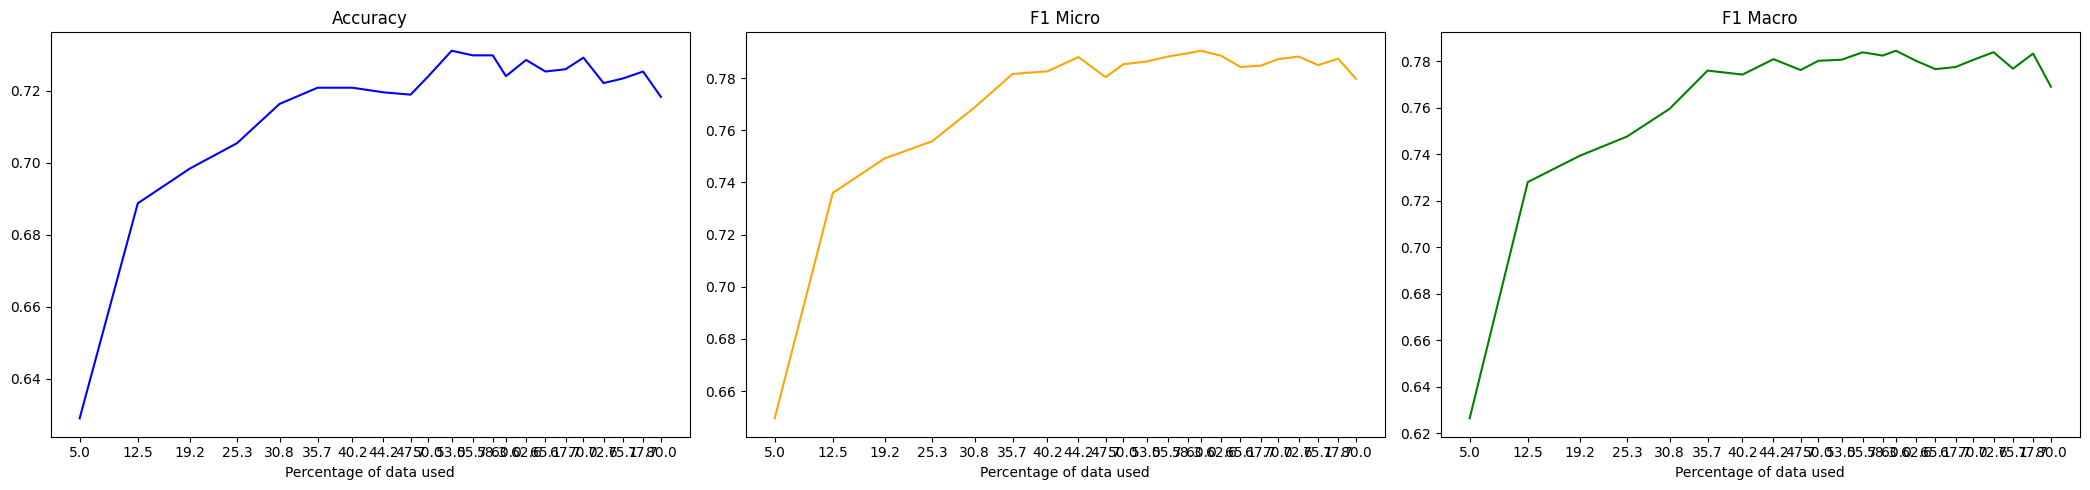

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.458386,0.505466,1.000000,0.080694,0.149337,0.114072
2,No log,0.384749,0.584566,0.914454,0.233786,0.372372,0.251831
3,No log,0.356113,0.571704,0.750000,0.348416,0.475798,0.347973
4,No log,0.330139,0.593569,0.773109,0.416290,0.541176,0.453938
5,No log,0.312512,0.608360,0.758850,0.517345,0.615247,0.548237
6,No log,0.303364,0.628296,0.745247,0.591252,0.659378,0.634356
7,No log,0.297518,0.625080,0.737660,0.608597,0.666942,0.633439
8,No log,0.296958,0.624437,0.752000,0.567119,0.646604,0.609105
9,No log,0.293293,0.627653,0.743662,0.597285,0.662484,0.635006
10,No log,0.293404,0.627653,0.747126,0.588235,0.658228,0.629208


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.62508038585209, F1 Micro: 0.6669421487603305, F1 Macro: 0.6334393870554681
                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.00233133723959327
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 42.747541427612305 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.383095,0.585209,0.800000,0.413273,0.545002,0.496891
2,No log,0.310498,0.643730,0.786735,0.581448,0.668690,0.655849
3,No log,0.290935,0.663666,0.707232,0.766968,0.735890,0.733469
4,No log,0.275142,0.675884,0.716851,0.782805,0.748378,0.741287
5,No log,0.274385,0.682958,0.726579,0.789593,0.756776,0.751094
6,No log,0.265277,0.688746,0.760317,0.722474,0.740913,0.735448
7,No log,0.266958,0.682958,0.739067,0.764706,0.751668,0.743786
8,No log,0.266762,0.690675,0.757716,0.740573,0.749047,0.741255
9,0.288000,0.266339,0.695177,0.771817,0.726998,0.748738,0.742051
10,0.288000,0.267747,0.693891,0.756839,0.751131,0.753974,0.745865


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.87      0.89       362
                sara       0.60      0.67      0.63       237
         radikalisme       0.68      0.86      0.76       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.73      0.79      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.73      0.79      0.76      1326
         samples avg       0.43      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6829581993569132, F1 Micro: 0.7567762920130106, F1 Macro: 0.7510935971908632
                      precision    recall  f1-score   support

          pornografi       0.91      0.87      0.89       362
                sara       0.60      0.67      0.63       237
         radikalisme       0.68      0.86      0.76       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.73      0.79      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.73      0.79      0.76      1326
         samples avg       0.43      0.44      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0033084240742027766
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 38.46542191505432 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.359282,0.601929,0.731550,0.598039,0.658091,0.654213
2,No log,0.295099,0.663666,0.731873,0.730769,0.731321,0.723616
3,No log,0.261515,0.690675,0.766453,0.720211,0.742613,0.731268
4,No log,0.257084,0.677814,0.736351,0.773002,0.754231,0.748690
5,No log,0.251849,0.701608,0.760574,0.759427,0.760000,0.756906
6,0.339500,0.255744,0.697106,0.750916,0.773002,0.761799,0.755452
7,0.339500,0.259139,0.692605,0.750367,0.770739,0.760417,0.756166
8,0.339500,0.262958,0.695177,0.747093,0.775264,0.760918,0.753465
9,0.339500,0.262749,0.703537,0.759910,0.766214,0.763049,0.758703
10,0.339500,0.264973,0.702251,0.755523,0.773756,0.764531,0.757840


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.71      0.79      0.75       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.76      0.77      0.77      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.7022508038585209, F1 Micro: 0.7645305514157974, F1 Macro: 0.7578396563248103
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.71      0.79      0.75       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.76      0.77      0.77      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0053020420018583545
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 34.8545401096344 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.340304,0.610289,0.715328,0.665158,0.689332,0.661978
2,No log,0.277711,0.680386,0.784843,0.679487,0.728375,0.721322
3,No log,0.257278,0.687460,0.766234,0.711916,0.738077,0.727403
4,No log,0.249401,0.695820,0.756152,0.764706,0.760405,0.754091
5,0.374900,0.258568,0.692605,0.739929,0.789593,0.763955,0.757706
6,0.374900,0.264382,0.699035,0.741234,0.797134,0.768169,0.763300
7,0.374900,0.258909,0.696463,0.765337,0.752640,0.758935,0.753367
8,0.374900,0.261321,0.699678,0.767732,0.742836,0.755079,0.745798
9,0.196600,0.265661,0.699035,0.763037,0.750377,0.756654,0.748832
10,0.196600,0.268474,0.700965,0.757485,0.763198,0.760331,0.752211


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.69      0.87      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.80      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6990353697749196, F1 Micro: 0.7681686046511628, F1 Macro: 0.7633000399215057
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.91       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.69      0.87      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.80      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0031351923476904647
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 31.29958939552307 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.324751,0.634727,0.741117,0.660633,0.698565,0.678790
2,No log,0.265267,0.682315,0.792287,0.681750,0.732874,0.702236
3,No log,0.243119,0.708682,0.777864,0.757919,0.767762,0.760455
4,0.381900,0.239671,0.697106,0.810206,0.682504,0.740892,0.722964
5,0.381900,0.247303,0.719614,0.764020,0.791101,0.777325,0.771886
6,0.381900,0.246186,0.717042,0.778539,0.771493,0.775000,0.767920
7,0.214800,0.256583,0.711897,0.780660,0.748869,0.764434,0.750541
8,0.214800,0.256642,0.713826,0.773900,0.769231,0.771558,0.763902
9,0.214800,0.263944,0.720257,0.767988,0.788839,0.778274,0.773305
10,0.141200,0.265656,0.717685,0.768833,0.785068,0.776866,0.770885


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7202572347266881, F1 Micro: 0.7782738095238096, F1 Macro: 0.7733048284255238
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.003186435322277249
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 28.26558804512024 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.311793,0.639228,0.738424,0.685520,0.710989,0.711271
2,No log,0.254038,0.696463,0.792631,0.697587,0.742078,0.725909
3,0.386500,0.242375,0.705466,0.778839,0.738311,0.758033,0.744563
4,0.386500,0.237082,0.718971,0.803156,0.729261,0.764427,0.756730
5,0.386500,0.236536,0.716399,0.795638,0.742836,0.768331,0.761523
6,0.234300,0.248807,0.725402,0.771408,0.801659,0.786243,0.781435
7,0.234300,0.255927,0.721543,0.778195,0.780543,0.779367,0.772056
8,0.234300,0.257109,0.720257,0.784195,0.778281,0.781226,0.772453
9,0.150500,0.264671,0.719614,0.777694,0.778281,0.777987,0.770570
10,0.150500,0.267085,0.722830,0.777944,0.782051,0.779992,0.772107


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7254019292604501, F1 Micro: 0.786242603550296, F1 Macro: 0.7814348086194319
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.001955565996468067
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 25.492600679397583 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289915,0.669453,0.783229,0.662142,0.717613,0.699333
2,No log,0.247072,0.705466,0.767722,0.767722,0.767722,0.758455
3,0.385400,0.233459,0.727331,0.787597,0.766214,0.776758,0.770185
4,0.385400,0.232575,0.723473,0.788506,0.776018,0.782212,0.776957
5,0.385400,0.233180,0.719614,0.788984,0.766968,0.777820,0.771153
6,0.241900,0.241065,0.724116,0.796863,0.766214,0.781238,0.775584
7,0.241900,0.251043,0.722830,0.791469,0.755656,0.773148,0.765737
8,0.159000,0.264335,0.729260,0.779434,0.788839,0.784108,0.778611
9,0.159000,0.267587,0.727331,0.776952,0.788084,0.782478,0.776053
10,0.159000,0.268398,0.724116,0.776620,0.786576,0.781566,0.776095


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.68      0.65      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7292604501607717, F1 Micro: 0.7841079460269864, F1 Macro: 0.7786114073501155
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.68      0.65      0.66       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.001265982340555638
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 22.94605851173401 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.301113,0.578135,0.682671,0.686275,0.684468,0.679247
2,No log,0.246052,0.708682,0.780488,0.748115,0.763958,0.755301
3,0.384500,0.238832,0.715113,0.758941,0.800151,0.779001,0.772373
4,0.384500,0.231744,0.716399,0.798374,0.740573,0.768388,0.759072
5,0.245800,0.241600,0.718328,0.779378,0.775264,0.777316,0.773236
6,0.245800,0.245118,0.713826,0.781565,0.760935,0.771112,0.762383
7,0.170300,0.262055,0.716399,0.775771,0.777526,0.776648,0.768973
8,0.170300,0.263879,0.721543,0.787666,0.760935,0.774070,0.768027
9,0.170300,0.269663,0.726045,0.784344,0.770739,0.777482,0.772178
10,0.123500,0.274236,0.720900,0.772491,0.783560,0.777986,0.773254


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.715112540192926, F1 Micro: 0.7790014684287813, F1 Macro: 0.7723726091668268
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0009066810889635235
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 20.726665496826172 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274727,0.675241,0.800567,0.638763,0.710570,0.687081
2,No log,0.243330,0.702894,0.791493,0.715686,0.751683,0.734299
3,0.377300,0.229927,0.719614,0.777022,0.775264,0.776142,0.767037
4,0.377300,0.241090,0.720900,0.758840,0.809201,0.783212,0.776439
5,0.249000,0.240775,0.720900,0.768126,0.806938,0.787054,0.781236
6,0.249000,0.247698,0.718328,0.766715,0.795626,0.780903,0.776800
7,0.175200,0.256057,0.718328,0.780061,0.773002,0.776515,0.770005
8,0.175200,0.268671,0.714469,0.757511,0.798643,0.777533,0.772608
9,0.126500,0.274089,0.713826,0.759393,0.792609,0.775646,0.771400
10,0.126500,0.274494,0.713183,0.759622,0.788839,0.773955,0.769430


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.73      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7209003215434083, F1 Micro: 0.7870540639941155, F1 Macro: 0.7812361896427678
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.73      0.85      0.79       235
pencemaran_nama_baik       0.73      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 0.0005491747288033367
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 18.73076891899109 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.278571,0.673312,0.730296,0.761689,0.745663,0.737058
2,No log,0.239061,0.709325,0.765799,0.776772,0.771247,0.763380
3,0.374900,0.225901,0.721543,0.784195,0.778281,0.781226,0.773839
4,0.374900,0.233147,0.727974,0.775436,0.804676,0.789785,0.782823
5,0.246900,0.230240,0.724116,0.802400,0.756410,0.778727,0.769098
6,0.246900,0.243887,0.717685,0.762108,0.806938,0.783883,0.779677
7,0.176400,0.249256,0.725402,0.790199,0.778281,0.784195,0.777493
8,0.176400,0.261959,0.719614,0.778781,0.780543,0.779661,0.771052
9,0.126500,0.264579,0.721543,0.777612,0.785822,0.781695,0.777077
10,0.126500,0.270334,0.718328,0.771956,0.788839,0.780306,0.775212


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.72      0.89      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7279742765273312, F1 Micro: 0.7897853441894892, F1 Macro: 0.7828226676380157
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.72      0.89      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0004039371822727845
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 17.397790908813477 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262642,0.686174,0.782161,0.687783,0.731942,0.726353
2,0.367400,0.233507,0.706752,0.767976,0.781297,0.774579,0.764838
3,0.367400,0.230470,0.711254,0.816609,0.711916,0.760677,0.750575
4,0.243500,0.224641,0.722830,0.810273,0.737557,0.772207,0.758148
5,0.243500,0.235293,0.723473,0.812759,0.739819,0.774576,0.765856
6,0.175100,0.249980,0.717042,0.781417,0.773756,0.777567,0.770440
7,0.175100,0.262246,0.719614,0.769006,0.793363,0.780995,0.776962
8,0.129400,0.269366,0.719614,0.758133,0.808446,0.782482,0.778526
9,0.129400,0.269171,0.715756,0.776524,0.778281,0.777401,0.771390
10,0.100300,0.275128,0.717685,0.769514,0.788084,0.778689,0.773210


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7196141479099678, F1 Micro: 0.7824817518248176, F1 Macro: 0.7785261774432123
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.0001618126538232899
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 15.669125080108643 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262659,0.693891,0.768322,0.735294,0.751445,0.737702
2,0.362600,0.233594,0.715756,0.776336,0.766968,0.771624,0.764227
3,0.362600,0.229549,0.713826,0.751220,0.812971,0.780876,0.775944
4,0.240900,0.226611,0.722830,0.767442,0.796380,0.781643,0.775744
5,0.240900,0.234690,0.718971,0.783804,0.773756,0.778748,0.771904
6,0.177800,0.256297,0.718971,0.756184,0.806938,0.780737,0.777475
7,0.177800,0.254962,0.718971,0.768837,0.792609,0.780542,0.775627
8,0.130000,0.268937,0.723473,0.770987,0.789593,0.780179,0.775837
9,0.130000,0.268604,0.719614,0.778032,0.769231,0.773606,0.766534
10,0.099200,0.274866,0.718328,0.763292,0.790347,0.776584,0.771294


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.61      0.71      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7228295819935692, F1 Micro: 0.7816432272390822, F1 Macro: 0.7757437401862228
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.61      0.71      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 0.00018710049189394332
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 14.133525609970093 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257583,0.690675,0.793488,0.698341,0.742880,0.720829
2,0.355700,0.232623,0.702894,0.798822,0.715686,0.754972,0.736369
3,0.355700,0.219439,0.720900,0.797600,0.751885,0.774068,0.766604
4,0.240500,0.236373,0.709325,0.744361,0.821267,0.780925,0.774536
5,0.240500,0.237918,0.720900,0.769398,0.800151,0.784473,0.776768
6,0.182400,0.245525,0.722830,0.769120,0.803922,0.786136,0.779981
7,0.182400,0.259434,0.713183,0.761183,0.795626,0.778024,0.769340
8,0.130000,0.274713,0.724116,0.760446,0.823529,0.790731,0.785778
9,0.101800,0.271791,0.722186,0.779558,0.770739,0.775123,0.766195
10,0.101800,0.273801,0.719614,0.774146,0.785822,0.779940,0.772509


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.72      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7241157556270097, F1 Micro: 0.7907313540912383, F1 Macro: 0.7857775751344447
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.72      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 6.622194341616703e-05
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 12.81667947769165 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266439,0.661093,0.815846,0.574661,0.674336,0.652469
2,0.351200,0.230297,0.720900,0.771536,0.776772,0.774145,0.768041
3,0.351200,0.220059,0.733119,0.794992,0.766214,0.780338,0.773149
4,0.238400,0.226724,0.729904,0.779173,0.795626,0.787313,0.781448
5,0.238400,0.240573,0.718971,0.751374,0.825038,0.786485,0.782682
6,0.179100,0.247740,0.734405,0.784108,0.788839,0.786466,0.779611
7,0.129800,0.258446,0.721543,0.774627,0.782805,0.778695,0.771091
8,0.129800,0.268124,0.720900,0.770987,0.789593,0.780179,0.774047
9,0.104100,0.277025,0.718328,0.758993,0.795626,0.776878,0.772897
10,0.104100,0.280434,0.722830,0.763139,0.799397,0.780847,0.775343


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.72      0.86      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.729903536977492, F1 Micro: 0.7873134328358208, F1 Macro: 0.7814482542639912
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.72      0.86      0.79       235
pencemaran_nama_baik       0.76      0.74      0.75       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 8.803500386420647e-05
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 11.664193391799927 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249357,0.693891,0.757154,0.738311,0.747614,0.738454
2,0.340800,0.229188,0.709325,0.752155,0.789593,0.770419,0.766215
3,0.340800,0.224572,0.720900,0.770575,0.797888,0.783994,0.777418
4,0.238900,0.232272,0.728617,0.759221,0.822775,0.789721,0.783761
5,0.173000,0.238273,0.724116,0.780228,0.773756,0.776978,0.772703
6,0.173000,0.250826,0.722186,0.769400,0.792609,0.780832,0.773369
7,0.126800,0.265461,0.722830,0.764451,0.797888,0.780812,0.775848
8,0.126800,0.276992,0.718971,0.763441,0.803167,0.782800,0.778740
9,0.098000,0.278566,0.720900,0.772961,0.793363,0.783029,0.778163
10,0.082600,0.282177,0.718328,0.766376,0.794118,0.780000,0.775025


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.81      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7286173633440515, F1 Micro: 0.7897213174086136, F1 Macro: 0.7837610708965264
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.81      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 6.732545589329676e-05
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 10.148961305618286 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246567,0.703537,0.772977,0.742081,0.757214,0.751376
2,0.337400,0.234707,0.709968,0.741781,0.816742,0.777459,0.773447
3,0.337400,0.223921,0.725402,0.788820,0.766214,0.777353,0.771160
4,0.233700,0.228692,0.719614,0.770636,0.795626,0.782931,0.776244
5,0.172600,0.248203,0.716399,0.754178,0.816742,0.784214,0.776139
6,0.172600,0.251033,0.721543,0.775298,0.785822,0.780524,0.772676
7,0.129700,0.263259,0.722186,0.767626,0.804676,0.785714,0.776582
8,0.099000,0.269304,0.720257,0.791183,0.771493,0.781214,0.772879
9,0.099000,0.280159,0.717685,0.775056,0.787330,0.781145,0.774954
10,0.078000,0.285859,0.719614,0.776786,0.787330,0.782022,0.774282


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7221864951768489, F1 Micro: 0.7857142857142857, F1 Macro: 0.776581592525865
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 1.4846789599687378e-05
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 8.714919805526733 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249363,0.689389,0.827552,0.629713,0.715203,0.697657
2,0.331000,0.227029,0.707395,0.806751,0.720965,0.761450,0.741793
3,0.331000,0.222255,0.732476,0.783096,0.789593,0.786331,0.779260
4,0.225200,0.236552,0.718971,0.743624,0.835596,0.786932,0.783551
5,0.165100,0.238627,0.716399,0.814212,0.717195,0.762630,0.753358
6,0.165100,0.253218,0.723473,0.794510,0.763952,0.778931,0.770374
7,0.128900,0.275699,0.719614,0.777358,0.776772,0.777065,0.770627
8,0.092200,0.282969,0.717685,0.766836,0.798643,0.782416,0.774805
9,0.092200,0.291111,0.723473,0.765896,0.799397,0.782288,0.774906
10,0.078300,0.296249,0.720900,0.764368,0.802413,0.782929,0.776597


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.61      0.75      0.67       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7189710610932476, F1 Micro: 0.786931818181818, F1 Macro: 0.7835509998336216
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.61      0.75      0.67       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 2.601460728328675e-05
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 7.344995498657227 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249431,0.682958,0.753811,0.745852,0.749810,0.746074
2,0.324100,0.220749,0.722830,0.807850,0.745098,0.775206,0.762766
3,0.222400,0.225838,0.727974,0.798561,0.753394,0.775320,0.772613
4,0.222400,0.230549,0.715113,0.748971,0.823529,0.784483,0.779597
5,0.166800,0.236075,0.727331,0.810855,0.743590,0.775767,0.766288
6,0.125800,0.255959,0.721543,0.769899,0.802413,0.785820,0.780117
7,0.125800,0.277621,0.717685,0.759104,0.817496,0.787219,0.782486
8,0.096900,0.282978,0.719614,0.774908,0.791855,0.783290,0.777982
9,0.075300,0.289307,0.717685,0.774481,0.787330,0.780853,0.775321
10,0.075300,0.293502,0.717685,0.774170,0.791101,0.782544,0.776011


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.71      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.46      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7176848874598071, F1 Micro: 0.7872185911401597, F1 Macro: 0.7824859610130522
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.71      0.80      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.46      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 6.307755575107876e-06
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 5.95184063911438 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241245,0.703537,0.804598,0.686275,0.740741,0.720717
2,0.313000,0.220550,0.727974,0.783804,0.773756,0.778748,0.771076
3,0.216200,0.220763,0.727974,0.783410,0.769231,0.776256,0.769501
4,0.216200,0.239593,0.722186,0.766906,0.803922,0.784978,0.777172
5,0.161500,0.237616,0.724759,0.778193,0.785822,0.781989,0.772906
6,0.124400,0.249353,0.727331,0.782119,0.785068,0.783591,0.776266
7,0.124400,0.268138,0.728617,0.774689,0.798643,0.786483,0.778992
8,0.096500,0.285896,0.724759,0.770456,0.802413,0.786110,0.778361
9,0.074800,0.303603,0.717685,0.754704,0.816742,0.784498,0.778917
10,0.064100,0.299128,0.717685,0.767374,0.791101,0.779057,0.770955


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.76      0.79      0.78       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7286173633440515, F1 Micro: 0.7864834756776828, F1 Macro: 0.778991688274083
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.76      0.79      0.78       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 2.9212543267931324e-06
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 4.512352228164673 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.238072,0.697106,0.755041,0.762443,0.758724,0.750035
2,0.308100,0.219507,0.712540,0.809037,0.715686,0.759504,0.747353
3,0.213700,0.226021,0.722830,0.812075,0.720211,0.763389,0.750894
4,0.213700,0.234815,0.727974,0.769727,0.809201,0.788971,0.779278
5,0.161600,0.245228,0.730547,0.792320,0.762443,0.777095,0.760156
6,0.122000,0.257304,0.721543,0.776792,0.792609,0.784621,0.777754
7,0.093800,0.277338,0.722186,0.769737,0.794118,0.781737,0.772858
8,0.093800,0.289513,0.724759,0.777446,0.785068,0.781238,0.774353
9,0.073700,0.296149,0.719614,0.769118,0.788839,0.778853,0.772292
10,0.060200,0.304194,0.724759,0.764748,0.801659,0.782769,0.776916


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.93      0.93       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.73      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7279742765273312, F1 Micro: 0.7889705882352941, F1 Macro: 0.7792784157276708
                      precision    recall  f1-score   support

          pornografi       0.93      0.93      0.93       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.73      0.78      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 9.904439866659239e-06
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 3.0420515537261963 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.236963,0.702894,0.771518,0.743590,0.757296,0.747273
2,0.297700,0.224814,0.722830,0.770909,0.799397,0.784894,0.778217
3,0.207200,0.229427,0.724116,0.763869,0.809955,0.786237,0.778904
4,0.160000,0.234171,0.722830,0.767908,0.808446,0.787656,0.782442
5,0.160000,0.249888,0.724759,0.758380,0.819005,0.787527,0.781912
6,0.118900,0.259309,0.730547,0.781204,0.802413,0.791667,0.784361
7,0.093300,0.278558,0.721543,0.771324,0.791101,0.781087,0.774353
8,0.073100,0.295880,0.720900,0.765942,0.797134,0.781227,0.774225
9,0.073100,0.298278,0.715113,0.772727,0.782051,0.777361,0.772866
10,0.056800,0.304550,0.718971,0.767831,0.795626,0.781481,0.775362


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.69      0.66      0.67       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7305466237942122, F1 Micro: 0.7916666666666666, F1 Macro: 0.7843609741594786
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.69      0.66      0.67       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 1.7780582311388575e-06
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.6832330226898193 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243943,0.687460,0.817308,0.641026,0.718512,0.692413
2,0.296800,0.223037,0.708039,0.766467,0.772247,0.769346,0.754958
3,0.199800,0.226229,0.711254,0.747754,0.815988,0.780382,0.774834
4,0.154200,0.229225,0.726045,0.800475,0.762443,0.780997,0.765584
5,0.154200,0.245243,0.724116,0.796063,0.762443,0.778891,0.770200
6,0.124400,0.270055,0.715113,0.766205,0.793363,0.779548,0.771074
7,0.089200,0.269738,0.726688,0.787994,0.782051,0.785011,0.777412
8,0.071900,0.295335,0.720257,0.770290,0.801659,0.785661,0.778028
9,0.059000,0.301274,0.716399,0.770419,0.789593,0.779888,0.772292
10,0.059000,0.305702,0.718328,0.770682,0.800905,0.785503,0.780398


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7202572347266881, F1 Micro: 0.7856614929785662, F1 Macro: 0.7780284983850922
                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 376.61 seconds
Total runtime: 11469.731705665588 seconds


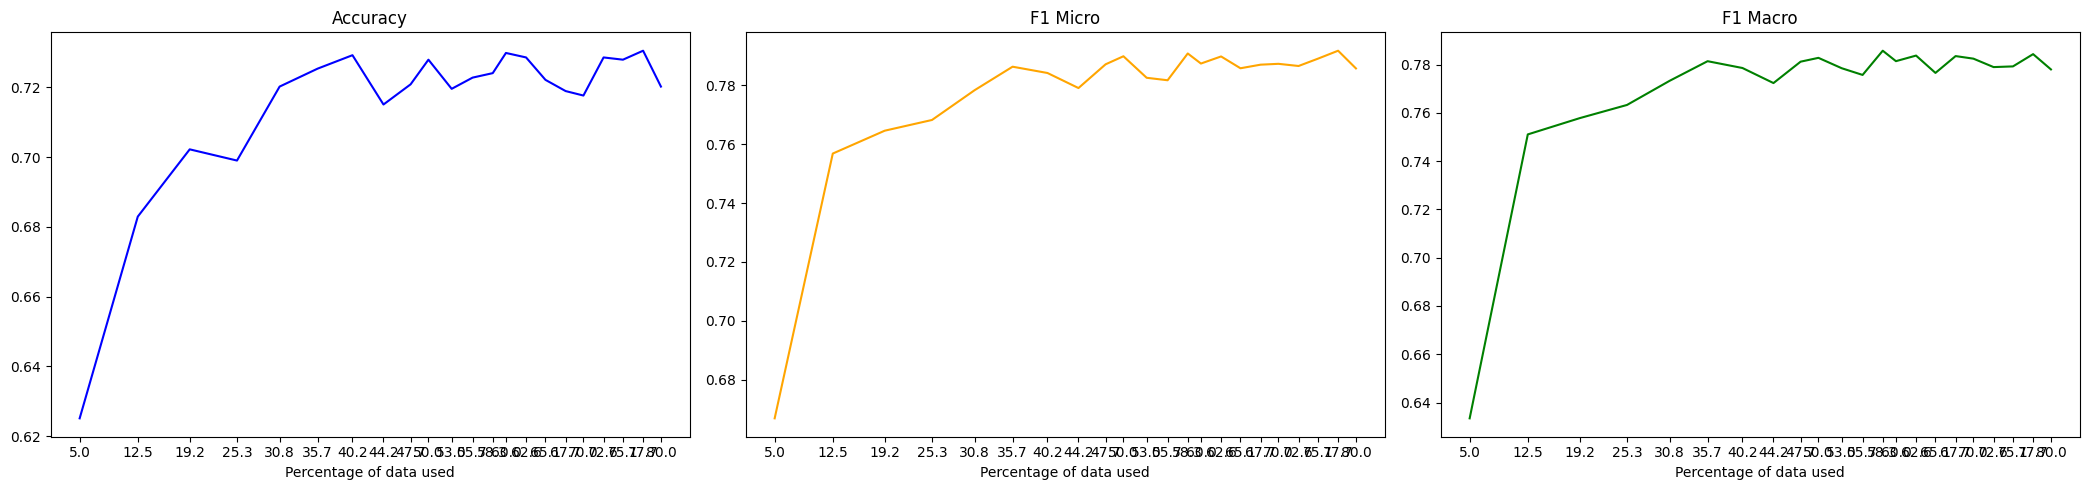

In [ ]:
active_learning(seeds[4], 4)